In [1]:
import matplotlib.pyplot as plt
from gym import spaces
from tqdm import tqdm
import os
from copy import deepcopy

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline

# Loading environment

['Lausanne', 'Geneva', 'Sion', 'NeuchÃ¢tel', 'Basel', 'Bern', 'LÃ¼cern', 'St-Gallen', 'ZÃ¼rich']


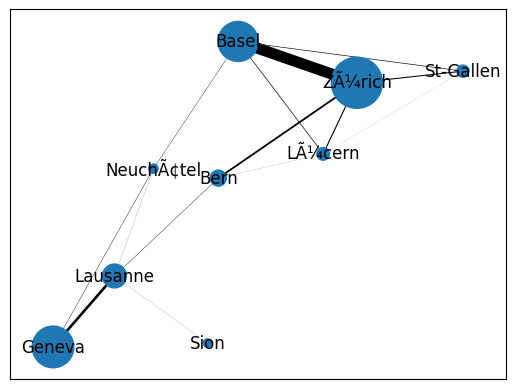

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
dyn.draw_map()

In [3]:
"""Loading the environment"""
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

""" Resetting the environment """
obs, info = env.reset(seed=0) # We pass a seed to the env to ensure reproductibility 

# Question 1

In [4]:
class DummyAgent(Agent):
    def __init__(self,  env:Env):
        """
        Dummy agent implementation. Just do nothing at each time step.
        """
        self.env = env
        self.dummy_action = { # DO NOTHING
            'confinement': False, 
            'isolation': False, 
            'hospital': False, 
            'vaccinate': False,
        }
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs, t=0, greedy=False):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        return self.dummy_action

In [5]:
def run_episode(env: Env, agent: Agent, seed: int):
    """ Run the simulation """
    log = []
    finished = False
    obs, info = env.reset(seed)
    log.append(info)
    # agent.reset()
    # agent.epsilon = 0
    
    cum_reward = 0
    while not finished:
        #print('dead_cost',env.dead_cost)
        #print('conf_cost', env.conf_cost)
        #print('ann_cost', env.ann_cost)
        #print('vacc_cost', env.vacc_cost)
        #print('hosp_cost', env.hosp_cost)
        #print('isol', env.isol)
        action = agent.act(obs, 0, greedy=True)
        env.dyn.last_action = info.action # important for Q4b
        obs, reward, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        cum_reward += reward
        if finished:
            break
        

    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return total, cities, actions, cum_reward

In [6]:
agent = DummyAgent(env)
total, cities, actions, _ = run_episode(env, agent, 2)

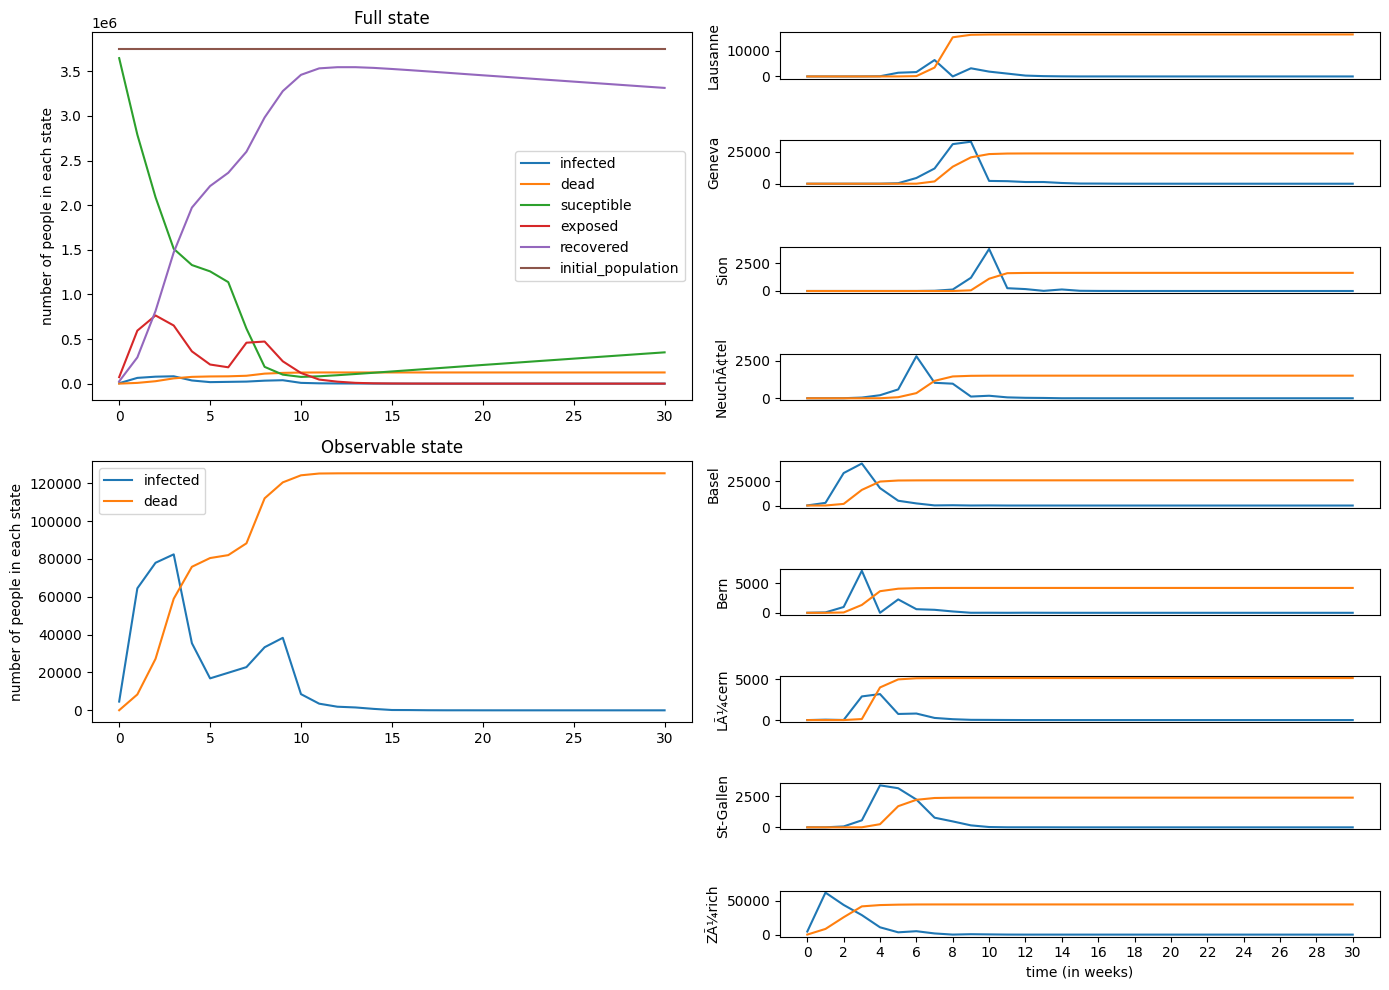

In [7]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

# Question 2

## Question 2 a

In [8]:
class RussoAgent(Agent):
    def __init__(self,  env:Env):
        """
        Russo's policy implementation.
        """
        self.env = env
        self.dummy_action = {
            # DO NOTHING
            'confinement': False, 
            'isolation': False, 
            'hospital': False, 
            'vaccinate': False,
        }
        self.confine_action = {
            # CONFINE
            'confinement': True, 
            'isolation': False, 
            'hospital': False, 
            'vaccinate': False,
        }
        self.confined_weeks = 0 # since how many weeks is the country confined
        self.confined = False
    
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        self.confined_weeks = 0 # since how many weeks is the country confined
        self.confined = False
    
    def act(self, obs, t=0, greedy=False):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        
        i_total = obs.total.infected[-1]
        threshold = 20000
        
        action = self.dummy_action
        if self.confined:
            if self.confined_weeks < 4: # confinement is not finished
                self.confined_weeks += 1
                action = self.confine_action # keep confined
            elif i_total > threshold: # confinement is finished but starts again
                self.confined_weeks = 1
                action = self.confine_action # re-confine
            else: # confinement is finished
                self.confined_weeks = 0
                self.confined = False
                action = self.dummy_action # release population
        
        elif i_total > threshold: # not confined yet, but threshold is reached
            self.confined = True
            self.confined_weeks +=1
            action = self.confine_action # confine
            
        return action

In [9]:
agent = RussoAgent(env)

total, cities, actions, _ = run_episode(env, agent, 2)

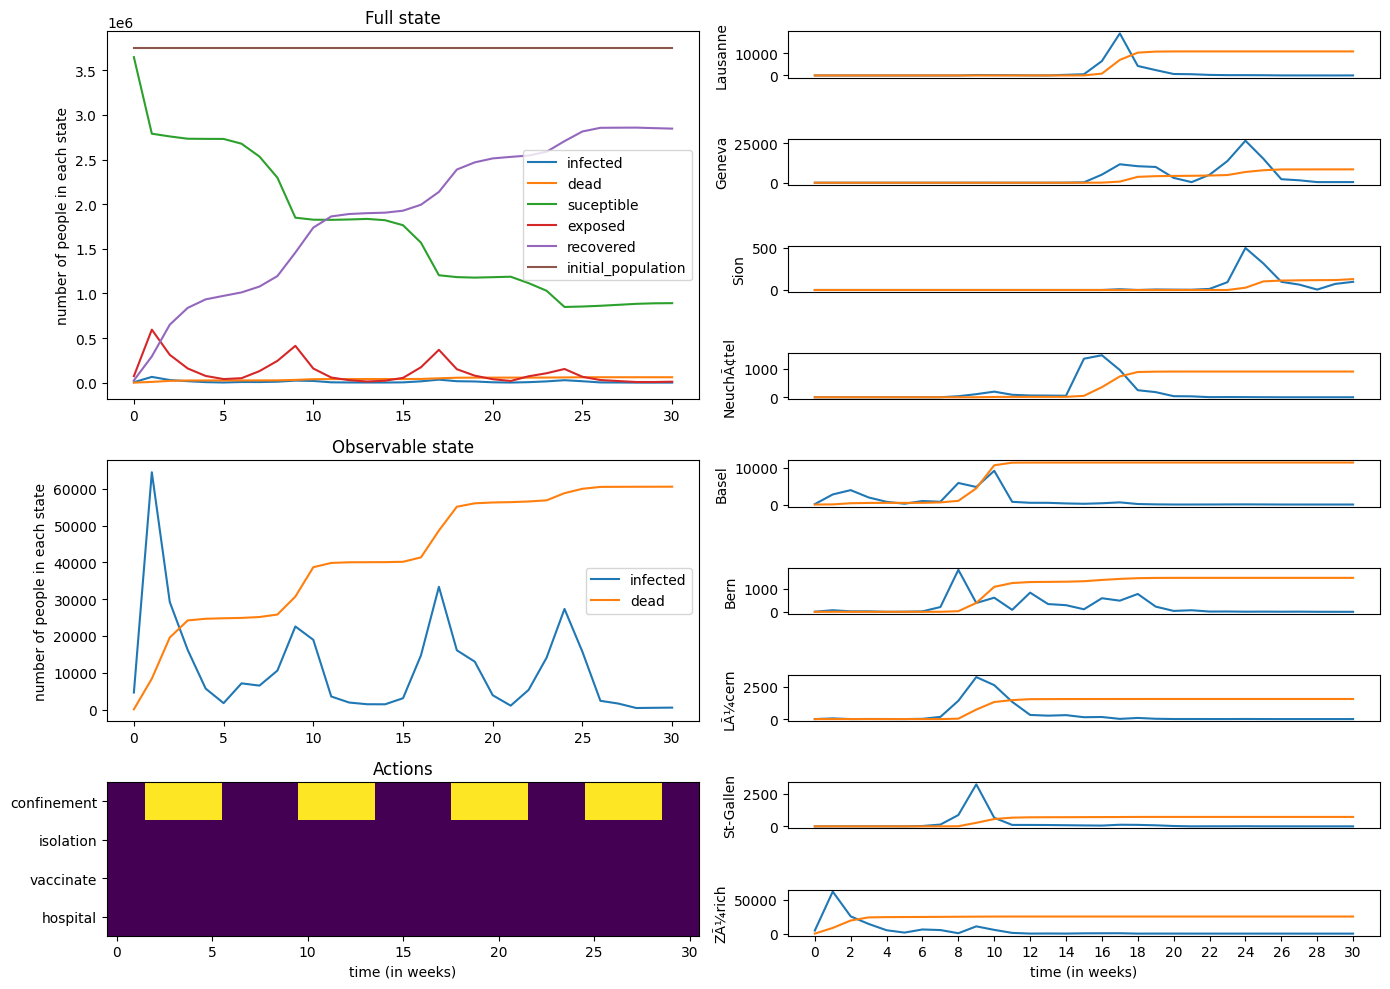

In [10]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

## Question 2 b

In [11]:
def evaluate(env: Env, agent: Agent, num_episodes=50):
    np.random.seed(2)
    confined_days = np.zeros(num_episodes, dtype=int)
    cum_rewards = np.zeros(num_episodes)
    total_deaths = np.zeros(num_episodes, dtype=int)
    for episode in range(num_episodes):
        total, _, actions, cum_reward = run_episode(env, agent, np.random.randint(0, 1000))
        confined_days[episode] = int(actions['confinement'].sum() * 7)
        cum_rewards[episode] = cum_reward
        total_deaths[episode] = total['dead'][-1]
    return confined_days, cum_rewards, total_deaths

In [12]:
agent.reset()
confined_days, cum_rewards, total_deaths = evaluate(env, agent)
print(confined_days.mean(), cum_rewards.mean(), total_deaths.mean())

100.24 -39.445920152664186 54321.12


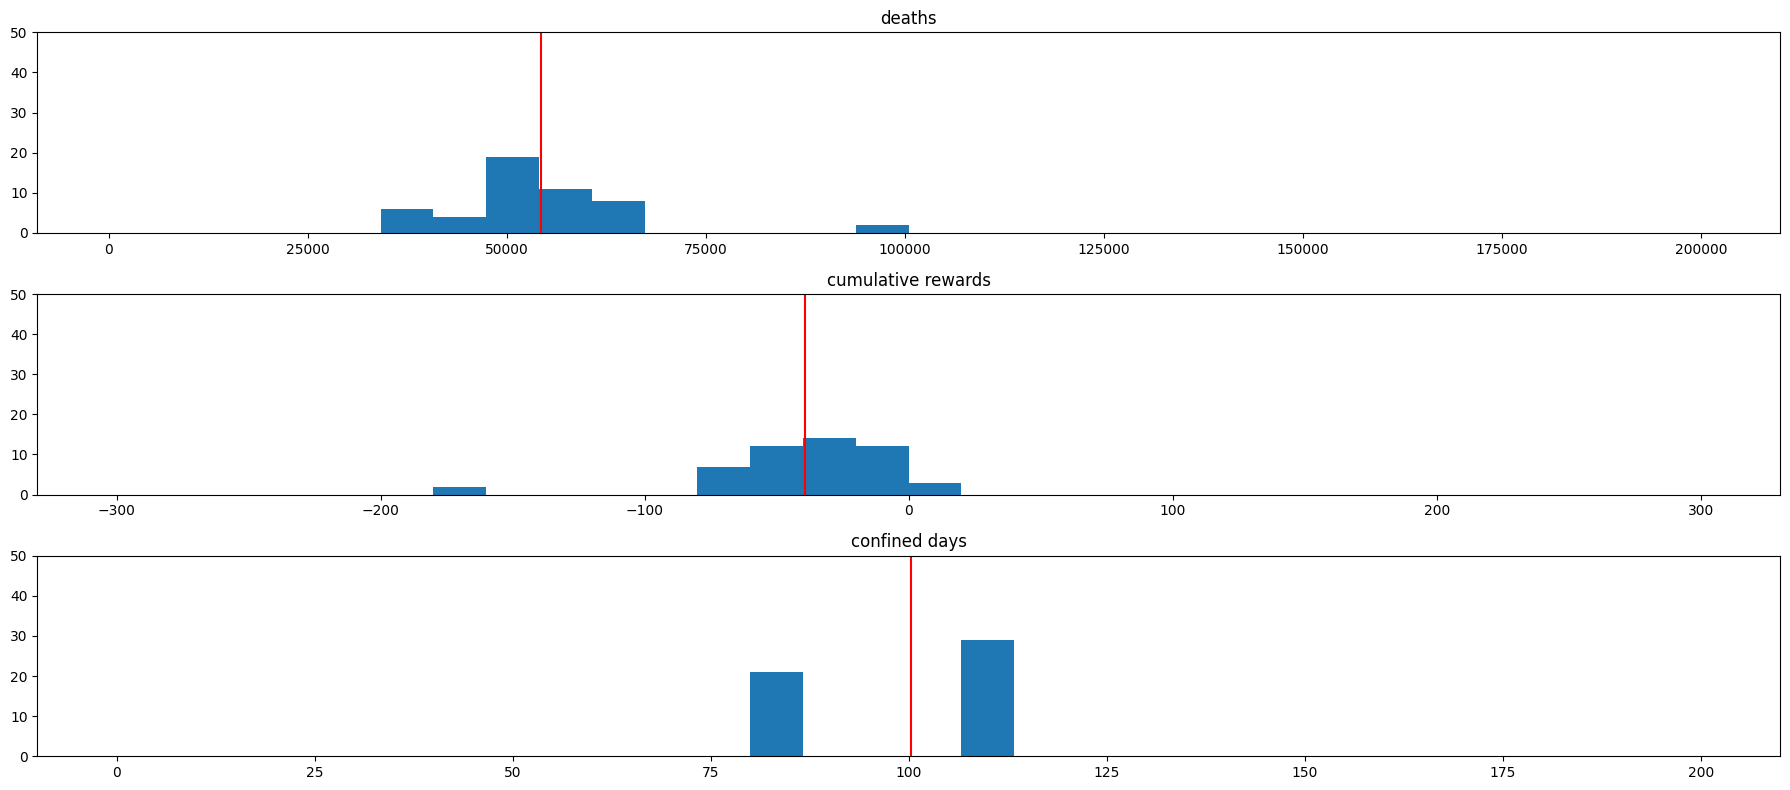

Average death number: 54321.12
Average number of confined days: 100.24
Average cumulative reward: -39.445920152664186


In [13]:
""" Plot histograms """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=30,range=x_range)
hist_avg(ax[0], total_deaths,'deaths')
hist_avg(ax[1], cum_rewards,'cumulative rewards')
hist_avg(ax[2], confined_days,'confined days')
fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(total_deaths)}')
print(f'Average number of confined days: {np.mean(confined_days)}')
print(f'Average cumulative reward: {np.mean(cum_rewards)}')

# Question 3

In [54]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor_Binary(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor_Binary(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

## Question 3a

In [15]:
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    
    def push(self, transition: Transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), size=batch_size, replace=False)
        return [self.memory[i] for i in indices]
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, obs_size, num_actions):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(obs_size, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 16)
        self.lin4 = nn.Linear(16, num_actions)

    def forward(self, x):
        h = F.relu(self.lin1(torch.pow(x, 0.25)))
        h = F.relu(self.lin2(h))
        h = F.relu(self.lin3(h))
        #h = F.selu(self.lin1(torch.pow(x, 0.25)))
        #h = F.selu(self.lin2(h))
        #h = F.selu(self.lin3(h))
        return self.lin4(h)

In [21]:
class DQNAgent(Agent):
    def __init__(self, 
                 env:Env, 
                 obs_size=2*9*7, 
                 num_actions=2, 
                 learning_rate=5e-3, 
                 gamma=0.9,
                 batch_size=2048,
                 eps_start=0.7, 
                 eps_end=0.7, 
                 t_max=500,
                 memory_capacity=20000):
        """
        Improve Russo's policy implementation.
        """
        self.env = env
        self.obs_size = obs_size
        self.num_actions = num_actions
        self.lr = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.policy_network = DQN(self.obs_size, self.num_actions)
        self.target_network = DQN(self.obs_size, self.num_actions)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=learning_rate, amsgrad=True)
        self.memory = ReplayBuffer(memory_capacity)
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.t_max = t_max
        self.memory_capacity = memory_capacity
        
        self.steps_done = 0
    
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.policy_network.load_state_dict(torch.load(os.path.join(savepath, 'policy.pt')))
        self.target_network.load_state_dict(torch.load(os.path.join(savepath, 'target.pt')))

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.policy_network.state_dict(), os.path.join(savepath, 'policy.pt'))
        torch.save(self.target_network.state_dict(), os.path.join(savepath, 'target.pt'))

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool
        )
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).reshape(self.batch_size, -1)
        state_batch = torch.cat(batch.state).reshape(self.batch_size, -1)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch.unsqueeze(1))
        # prints to debug Q4
        #print("action batch unsqueezed size", action_batch.unsqueeze(1).size())
        #print("output size of network", self.policy_network(state_batch).size())
        #print("Q(s,a) values size", state_action_values.size())

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        #print("loss",loss)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        self.policy_network = DQN(self.obs_size, self.num_actions)
        self.target_network = DQN(self.obs_size, self.num_actions)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayBuffer(self.memory_capacity)
        self.steps_done = 0
    
    def act(self, obs, t, greedy=False):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        eps_threshold = max(self.eps_start * (self.t_max - t) / self.t_max, self.eps_end)
        if greedy or np.random.random() > eps_threshold:
            with torch.no_grad():
                output = self.policy_network(obs.reshape(1, -1))
                return torch.argmax(output).item()
        else:
            return env.action_space.sample()
    
    def push_memory(self, transition: Transition):
        self.memory.push(transition)

In [22]:
def evaluate_Agent(env: Env, agent: Agent):
    with torch.no_grad():
        _, cum_rewards, _ = evaluate(env, agent, 20)
    return np.mean(cum_rewards)

In [23]:
from copy import deepcopy

def train_DQNBinaryAgent(env: Env, agent: DQNAgent, num_episodes: int, TAU: float, PATH: str, SEEDS: torch.Tensor):
    """ Train the agent """

    if not os.path.exists(PATH):
        os.makedirs(PATH)

    cum_rewards = np.zeros(num_episodes)
    eval_rewards = []
    best_reward = -np.inf
    
    
    for i_episode in tqdm(range(num_episodes)):
        obs, _ = env.reset(SEEDS[i_episode])
        finished = False
        while not finished:
            action = agent.act(obs, i_episode)
            next_obs, reward, finished, _ = env.step(action)
            cum_rewards[i_episode] += reward
            agent.push_memory(deepcopy(Transition(obs, action, next_obs, reward.item())))
            obs = next_obs
            agent.optimize_model()
            target_net_state_dict = agent.target_network.state_dict()
            policy_net_state_dict = agent.policy_network.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            agent.target_network.load_state_dict(target_net_state_dict)

        # Evaluate
        if i_episode % 50 == 0 or i_episode == num_episodes-1:
            eval_rew = evaluate_Agent(env, agent)
            eval_rewards.append(eval_rew)
            
    return cum_rewards, np.array(eval_rewards)

In [24]:
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_Binary,
            observation_preprocessor=observation_preprocessor_Binary,
            )
agent = DQNAgent(env)

100%|██████████| 500/500 [28:34<00:00,  3.43s/it]  


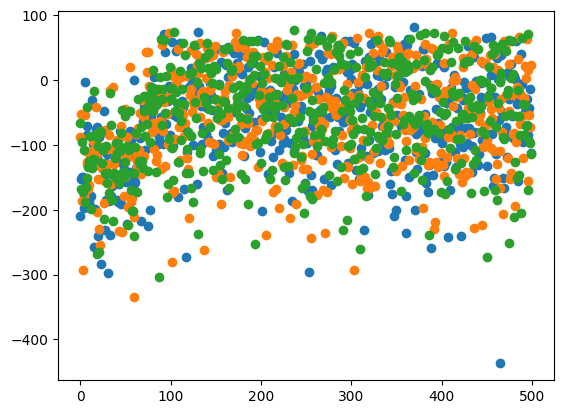

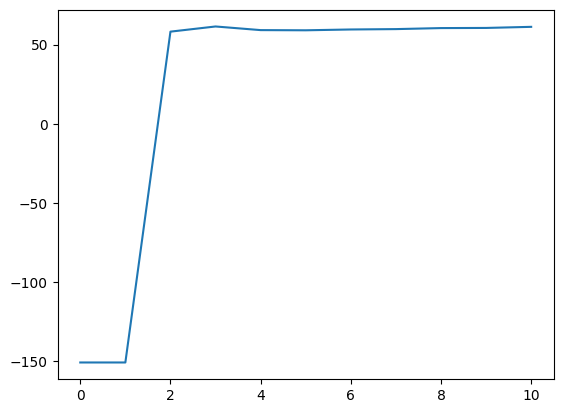

In [25]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

PATH = 'checkpoints/3a'
NUM_EPISODES = 500
TAU = 0.005 # tuto: 0.005
N_eval = np.ceil(NUM_EPISODES/50 + 1).astype(int)
eval_rewards = np.zeros((N_eval, 3))
best_reward = -np.inf
seeds = torch.randint(0,1000,(3,NUM_EPISODES))


for i in range(3):
    train_rewards, eval_rewards[:,i] = train_DQNBinaryAgent(env, agent, NUM_EPISODES, TAU, PATH, SEEDS = seeds[i])
    if eval_rewards[-1,i] > best_reward:
        best_reward = eval_rewards[-1,i]
        agent.save_model(PATH)
    plt.scatter(np.arange(NUM_EPISODES), train_rewards)
    agent.reset()

plt.figure()
plt.plot(eval_rewards.mean(axis=1))

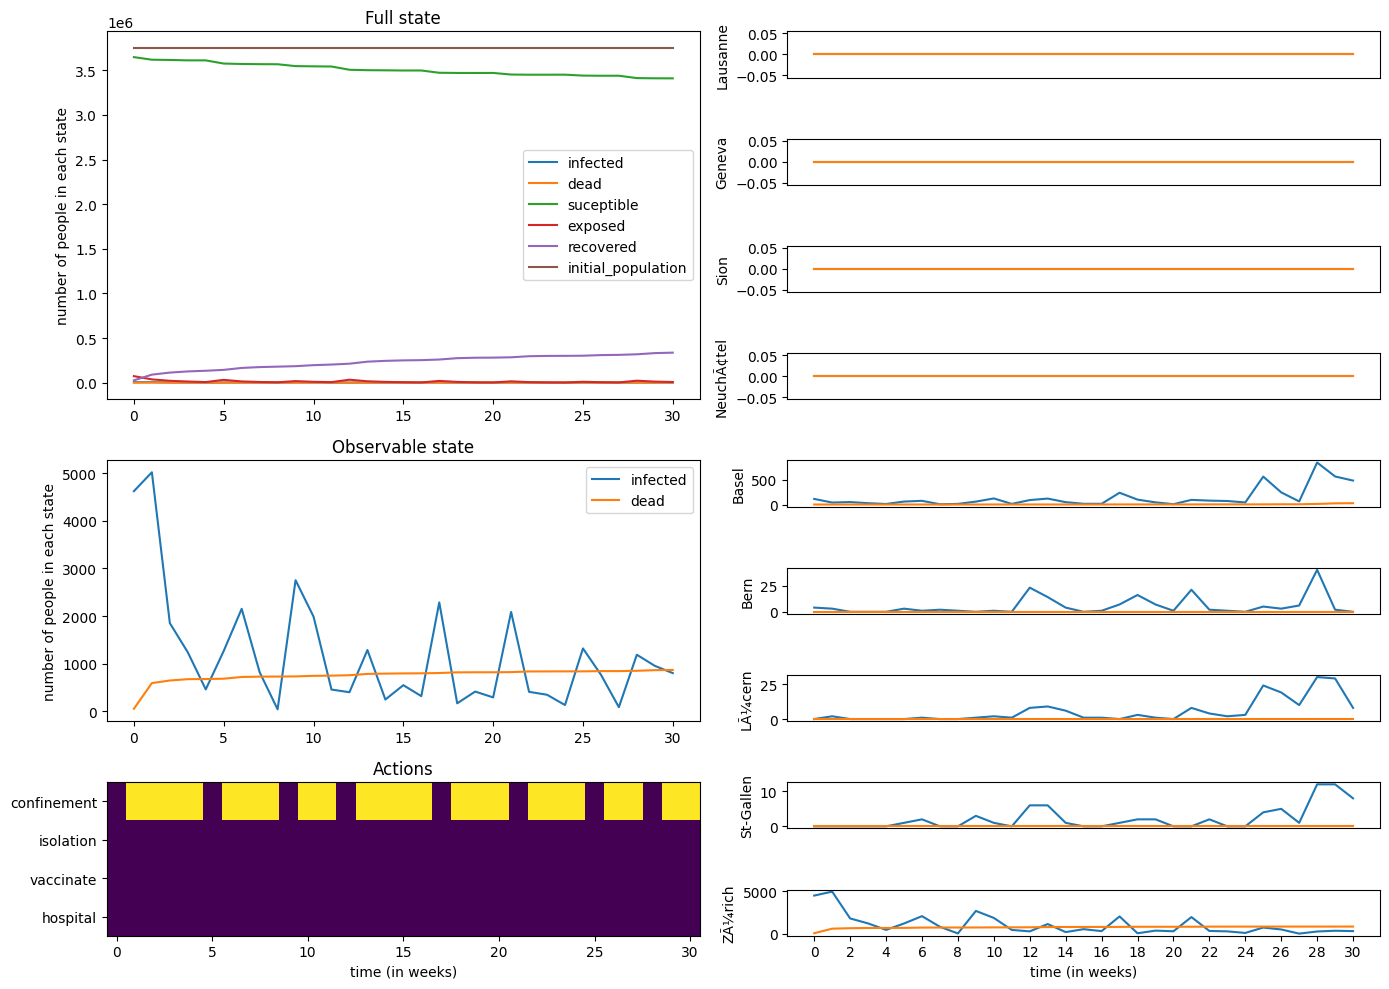

In [26]:
# reload agent
PATH = 'checkpoints/3a'
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, 2)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

152.88 64.0566877746582 2391.0


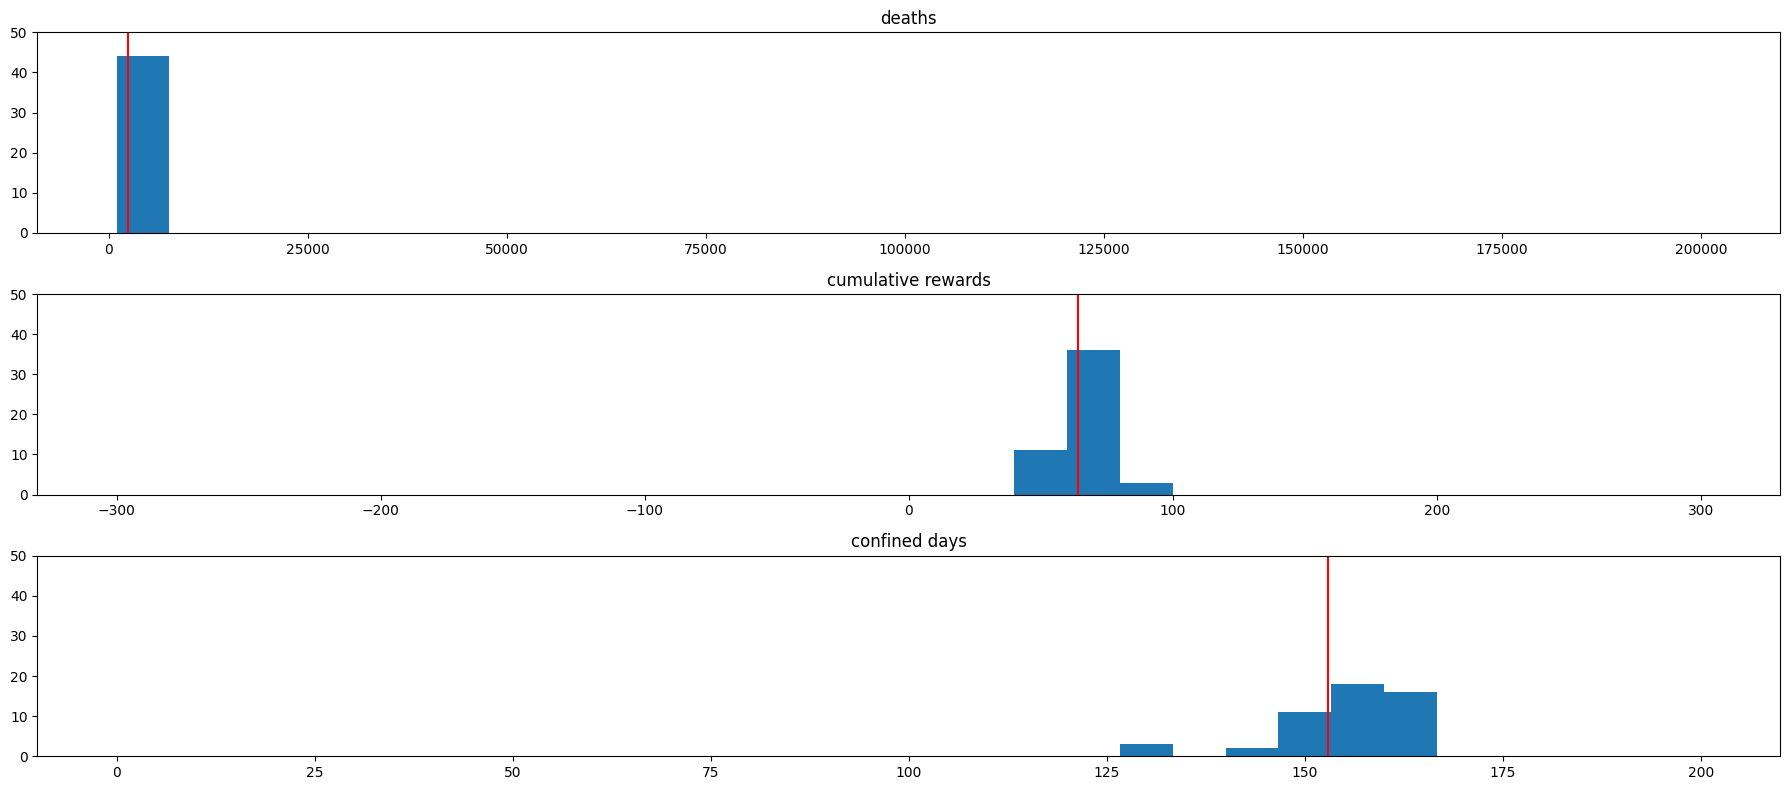

Average death number: 2391.0
Average number of confined days: 152.88
Average cumulative reward: 64.0566877746582


In [27]:
confined_days, cum_rewards, total_deaths = evaluate(env, agent)
print(confined_days.mean(), cum_rewards.mean(), total_deaths.mean())
""" Plot histograms """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=30,range=x_range)
hist_avg(ax[0], total_deaths,'deaths')
hist_avg(ax[1], cum_rewards,'cumulative rewards')
hist_avg(ax[2], confined_days,'confined days')
fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(total_deaths)}')
print(f'Average number of confined days: {np.mean(confined_days)}')
print(f'Average cumulative reward: {np.mean(cum_rewards)}')

## Question 3b

100%|██████████| 500/500 [25:48<00:00,  3.10s/it]  


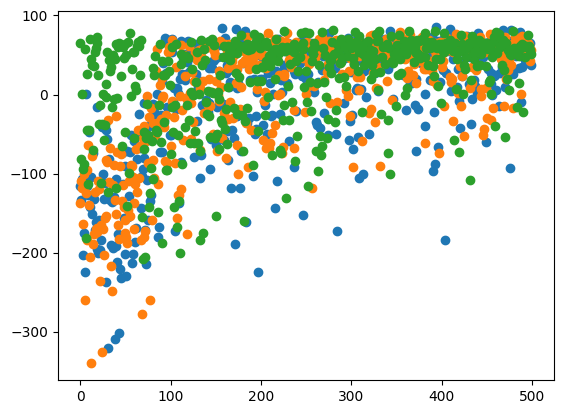

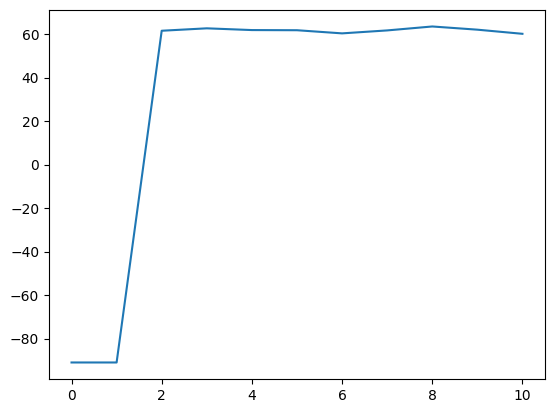

In [29]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

PATH = 'checkpoints/3b'
NUM_EPISODES = 500
TAU = 0.005

agent = DQNAgent(
    env,
    eps_start=0.7,
    eps_end=0.2,
    t_max=NUM_EPISODES,
)

N_eval = np.ceil(NUM_EPISODES/50 + 1).astype(int)
eval_rewards = np.zeros((N_eval, 3))
best_reward = -np.inf
seeds = torch.randint(0,1000,(3,NUM_EPISODES))

for i in range(3):
    train_rewards, eval_rewards[:,i] = train_DQNBinaryAgent(env, agent, NUM_EPISODES, TAU, PATH, SEEDS=seeds[i])
    if eval_rewards[-1,i] > best_reward:
        best_reward = eval_rewards[-1,i]
        agent.save_model(PATH)
    plt.scatter(np.arange(NUM_EPISODES), train_rewards)
    agent.reset()

plt.figure()
plt.plot(eval_rewards.mean(axis=1))

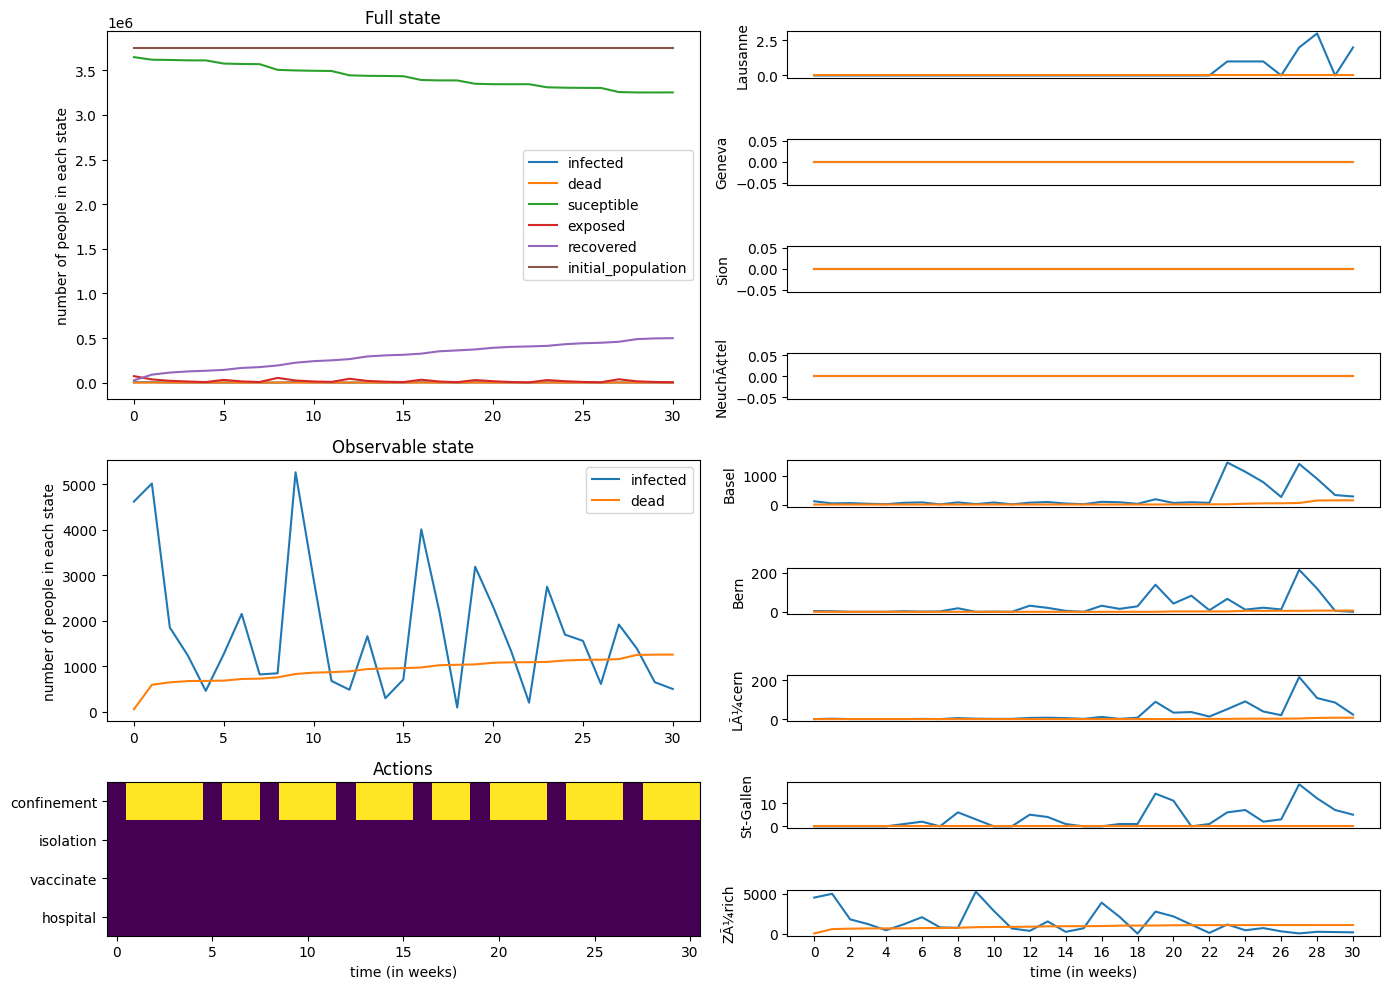

In [30]:
# reload agent
PATH = 'checkpoints/3b'
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, 2)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

151.62 63.26761169433594 3002.44


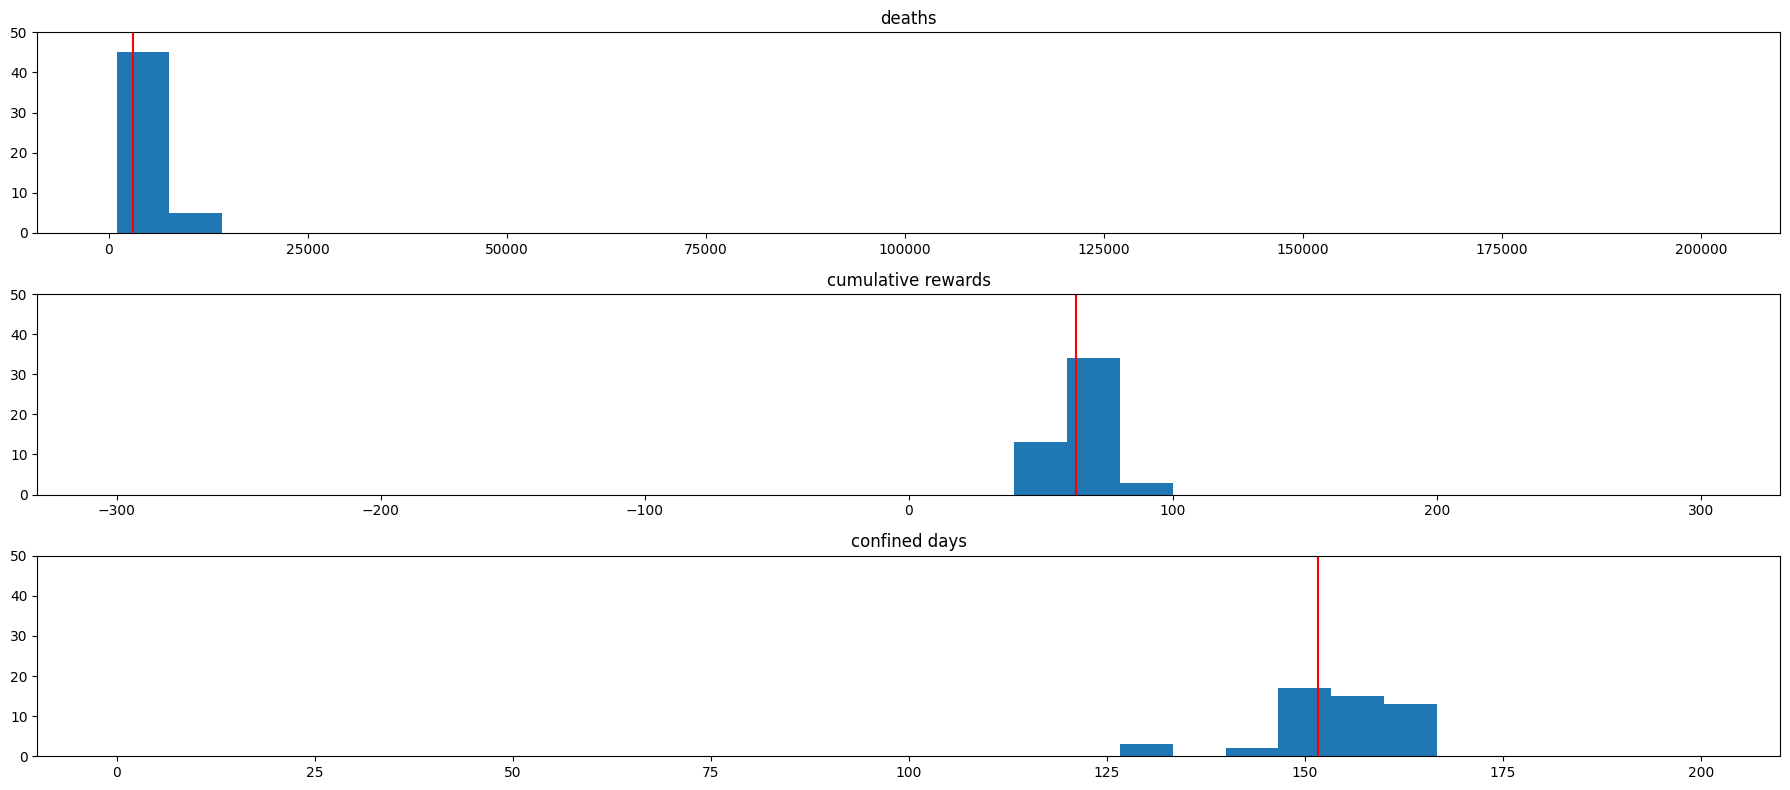

Average death number: 3002.44
Average number of confined days: 151.62
Average cumulative reward: 63.26761169433594


In [31]:
confined_days, cum_rewards, total_deaths = evaluate(env, agent)
print(confined_days.mean(), cum_rewards.mean(), total_deaths.mean())
""" Plot histograms """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=30,range=x_range)
hist_avg(ax[0], total_deaths,'deaths')
hist_avg(ax[1], cum_rewards,'cumulative rewards')
hist_avg(ax[2], confined_days,'confined days')
fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(total_deaths)}')
print(f'Average number of confined days: {np.mean(confined_days)}')
print(f'Average cumulative reward: {np.mean(cum_rewards)}')

# Question 4

### Question 4.1.b)

In [55]:
SCALE = 100
CHANGE_NOTHING = 0
TOOGLE_CONFINEMENT = 1
TOOGLE_ISOLATION = 2
TOOGLE_VACCINATION = 3
TOOGLE_HOSPITALISATION = 4



def action_preprocessor_Toggle(a:torch.Tensor, dyn:ModelDynamics):
    # a is the toggle action
    # env action below
    action = dyn.last_action.copy() # copy is important otherwise the modification acts on dyn
    if a == TOOGLE_CONFINEMENT:
        action['confinement'] = not(action['confinement'])
    elif a == TOOGLE_ISOLATION:
        action['isolation'] = not(action['isolation'])
    elif a == TOOGLE_VACCINATION:
        action['vaccinate'] = not(action['vaccinate'])
    elif a == TOOGLE_HOSPITALISATION:
        action['hospital'] = not(action['hospital'])
    
    return action # env action
    
def observation_preprocessor_Toggle(obs: Observation, dyn:ModelDynamics):
    #print("env action after toggle", dyn.get_action())
    last_action = np.array(list(dyn.get_action().copy().values())).astype(float)
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.concatenate((last_action, infected.flatten(), dead.flatten()))).unsqueeze(0)

In [33]:
from copy import deepcopy

def train_DQNToggleAgent(env: Env, agent: DQNAgent, num_episodes: int, TAU: float, PATH: str, SEEDS: torch.Tensor):
    """ Train the agent """

    if not os.path.exists(PATH):
        os.makedirs(PATH)

    cum_rewards = np.zeros(num_episodes)
    eval_rewards = []
    best_reward = -np.inf
    
    
    for i_episode in tqdm(range(num_episodes)):
        obs, info = env.reset(SEEDS[i_episode])
        finished = False
        while not finished:
            env.dyn.last_action = info.action # action of environment
            #print("last env action before obs", env.dyn.last_action)
            #print("last obs", obs)
            action = agent.act(obs, i_episode) # toggle action
            #print("toggle action", action)
            next_obs, reward, finished, info = env.step(action)
            #print("new env action before new obs", env.dyn.get_action())
            #print("new obs", next_obs)
            cum_rewards[i_episode] += reward
            agent.push_memory(deepcopy(Transition(obs, action, next_obs, reward.item())))
            obs = next_obs
            agent.optimize_model()
            target_net_state_dict = agent.target_network.state_dict()
            policy_net_state_dict = agent.policy_network.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            agent.target_network.load_state_dict(target_net_state_dict)

        # Evaluate
        if i_episode % 50 == 0 or i_episode == num_episodes-1:
            eval_rew = evaluate_Agent(env, agent)
            eval_rewards.append(eval_rew)
            
    return cum_rewards, np.array(eval_rewards)

In [34]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2 * dyn.n_cities * dyn.env_step_length + 4,),
                                    dtype=np.float16)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_Toggle,
            observation_preprocessor=observation_preprocessor_Toggle,
            )

100%|██████████| 3000/3000 [3:03:35<00:00,  3.67s/it]  


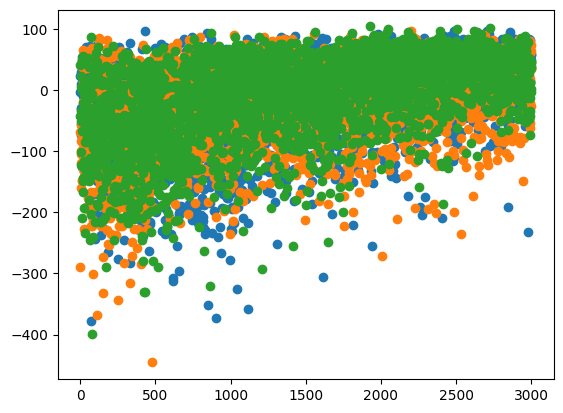

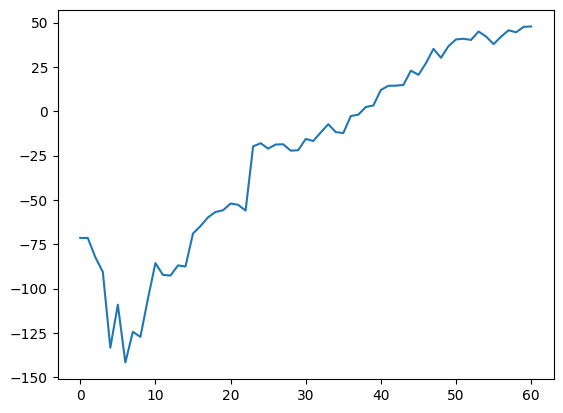

In [35]:
SEED = 2
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

PATH = 'checkpoints/4.1'
NUM_EPISODES = 3000
TAU = 0.005

agent = DQNAgent(
    env,
    obs_size = 2*9*7+4,
    num_actions=5,
    learning_rate= 1e-5, #1e-5 is asked,
    eps_start=0.7,
    eps_end=0.2,
    t_max=NUM_EPISODES,
)

N_eval = np.ceil(NUM_EPISODES/50 + 1).astype(int)
eval_rewards = np.zeros((N_eval, 3))
best_reward = -np.inf
seeds = torch.randint(0,3000,(3,NUM_EPISODES))
for i in range(3):
    train_rewards, eval_rewards[:,i] = train_DQNToggleAgent(env, agent, NUM_EPISODES, TAU, PATH, SEEDS=seeds[i])
    if eval_rewards[-1,i] > best_reward:
        best_reward = eval_rewards[-1,i]
        agent.save_model(PATH)
    plt.scatter(np.arange(NUM_EPISODES), train_rewards)
    agent.reset()

plt.figure()
plt.plot(eval_rewards.mean(axis=1))

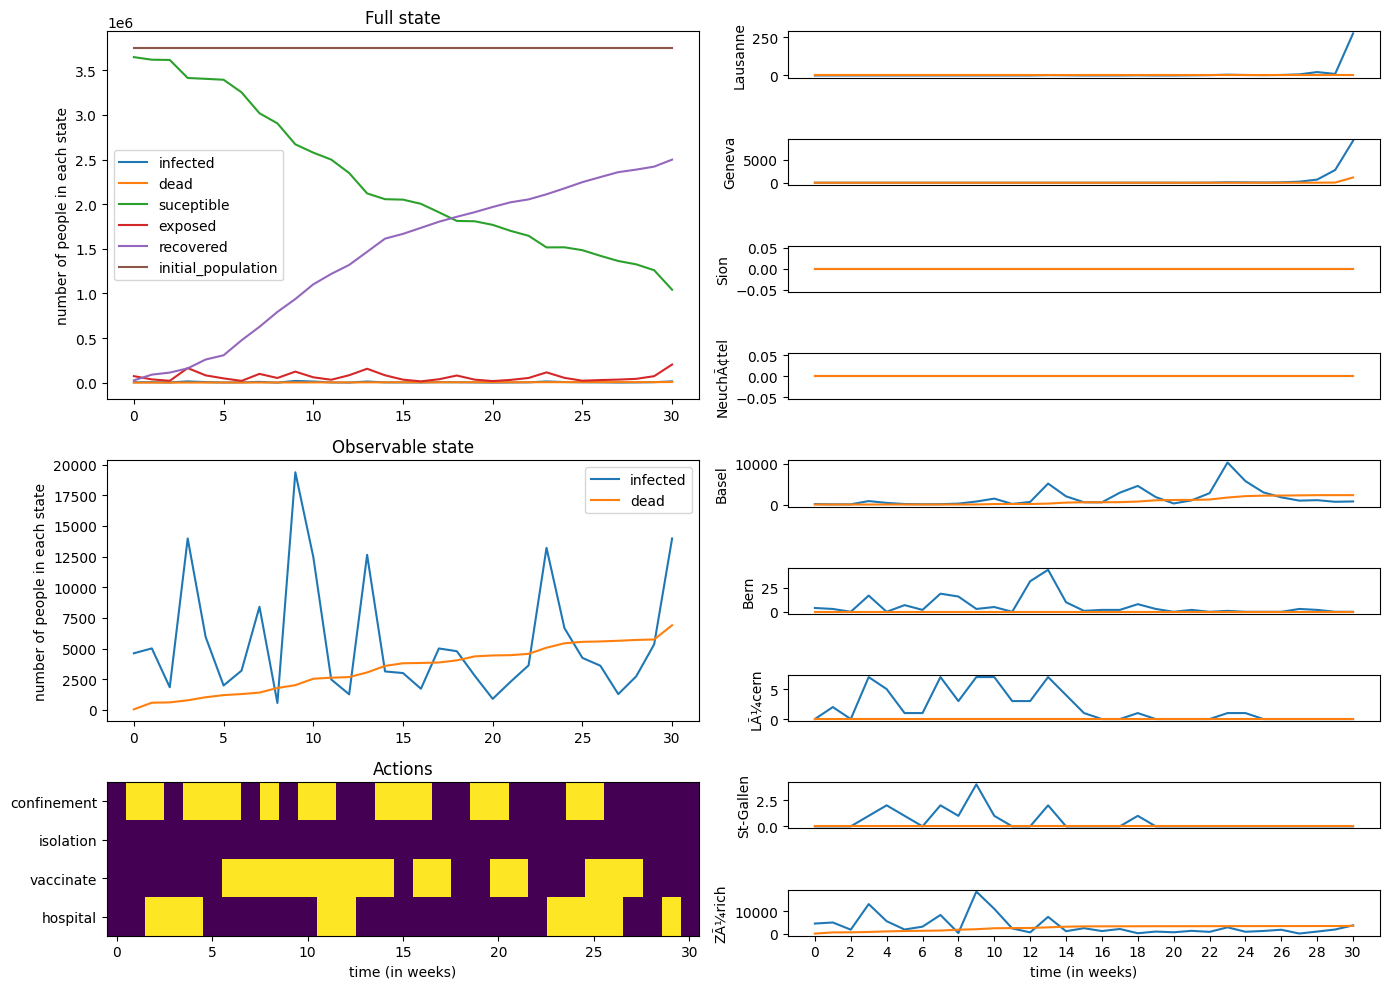

In [36]:
# reload agent
PATH = 'checkpoints/4.1'
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, seed=2)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')
[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

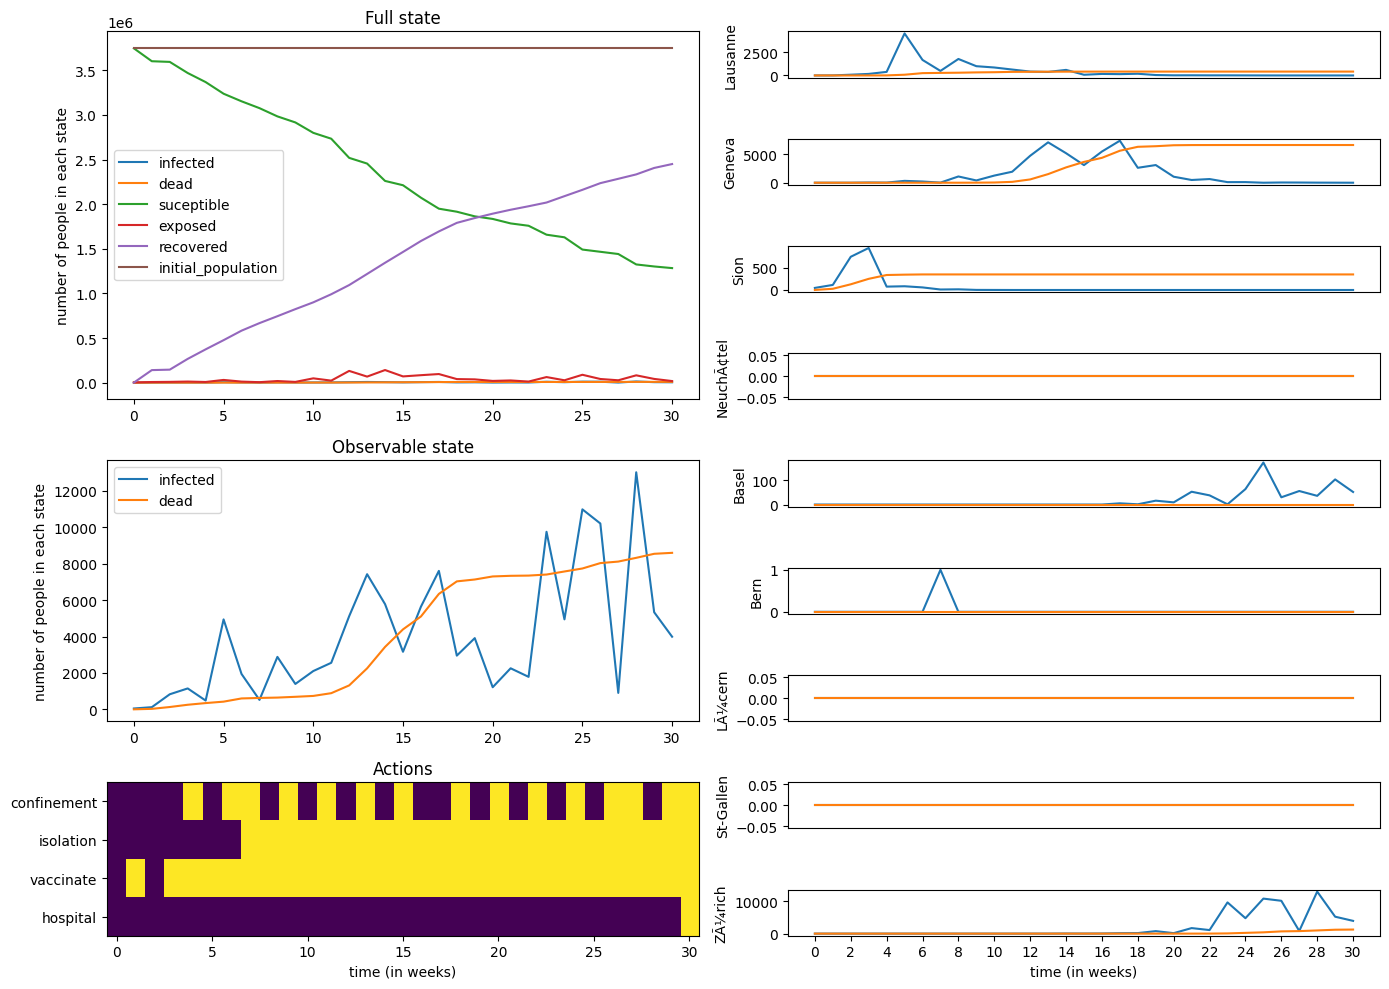

In [37]:
# reload agent
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, seed=3)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

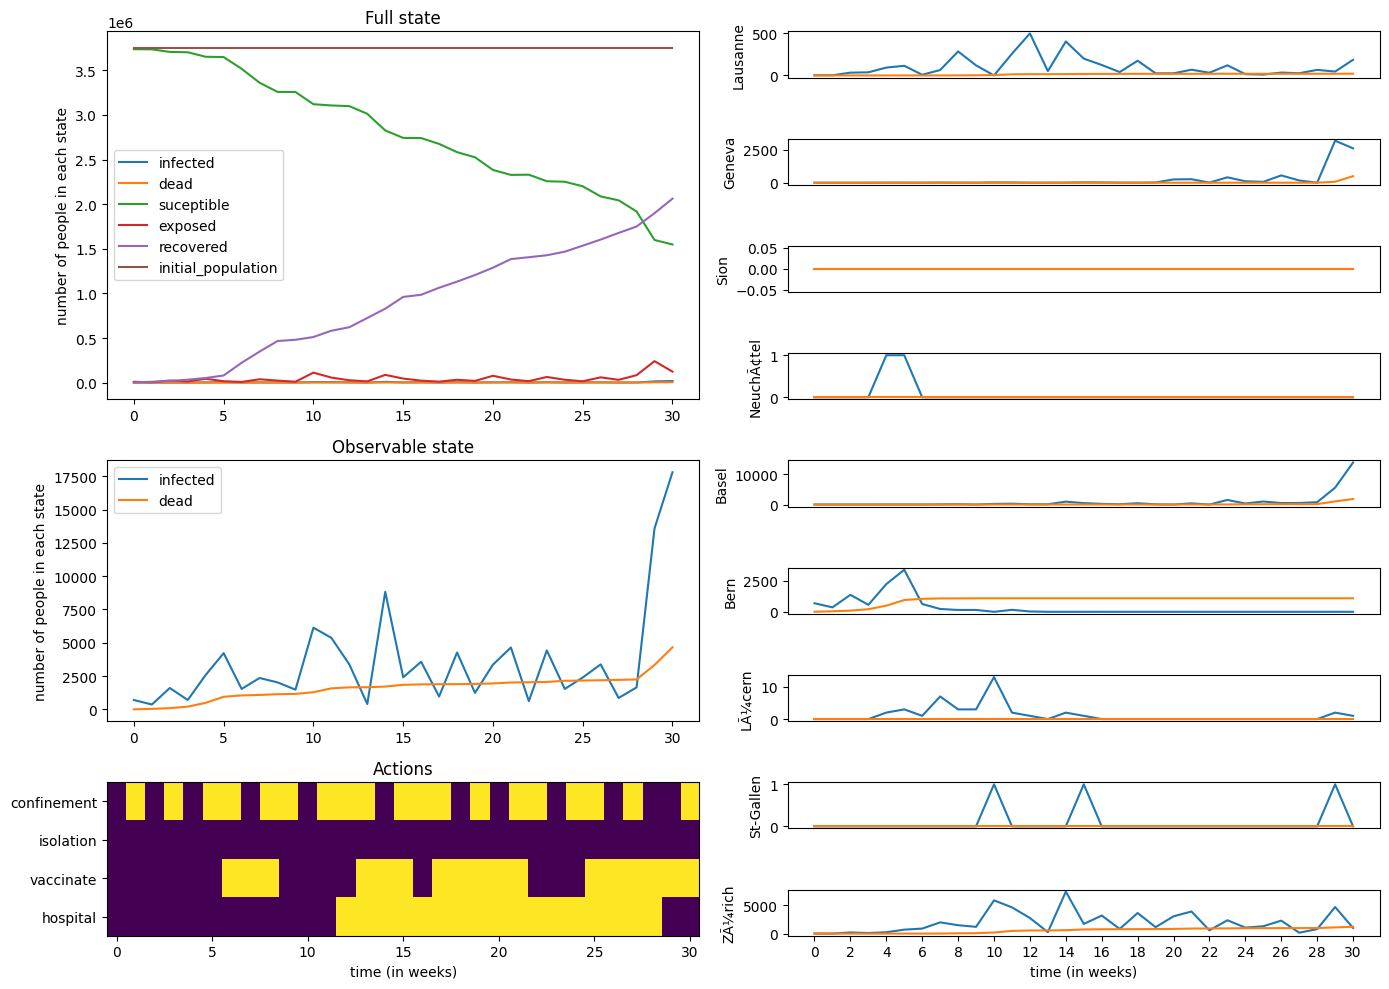

In [38]:
# reload agent
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, seed=5)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

112.56 57.4372692489624 11615.14


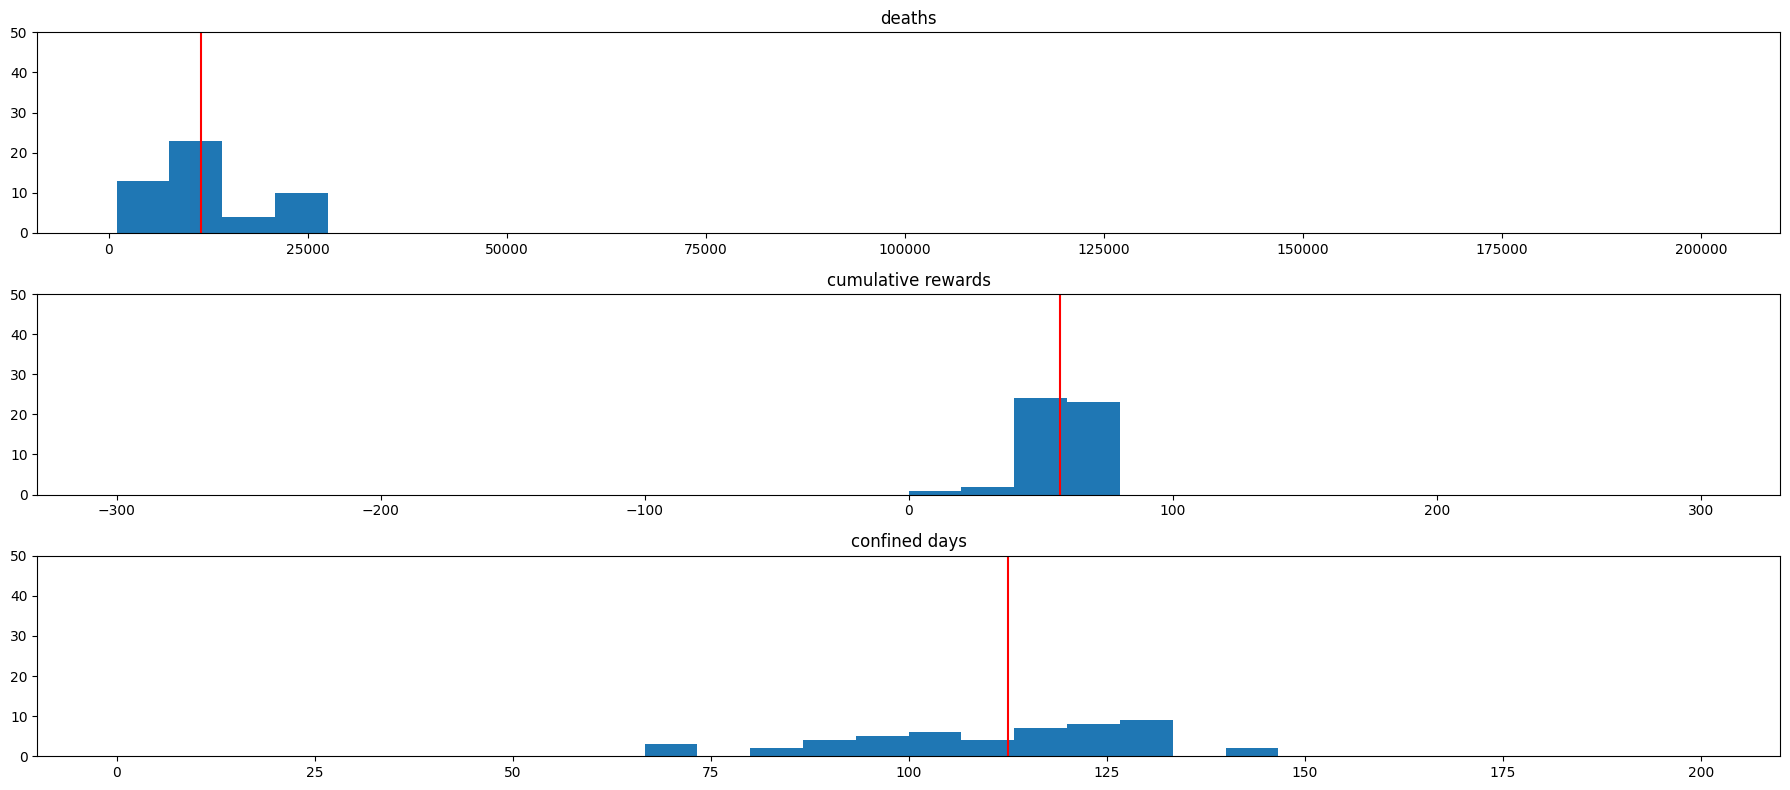

Average death number: 11615.14
Average number of confined days: 112.56
Average cumulative reward: 57.4372692489624


In [39]:
confined_days, cum_rewards, total_deaths = evaluate(env, agent)
#print(confined_days.mean(), cum_rewards.mean(), total_deaths.mean())
""" Plot histograms """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=30,range=x_range)
hist_avg(ax[0], total_deaths,'deaths')
hist_avg(ax[1], cum_rewards,'cumulative rewards')
hist_avg(ax[2], confined_days,'confined days')
fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(total_deaths)}')
print(f'Average number of confined days: {np.mean(confined_days)}')
print(f'Average cumulative reward: {np.mean(cum_rewards)}')

### Question 4.2.a)

In [40]:
class DQN_MultiAction(nn.Module):
    def __init__(self, obs_size, num_actions):
        super(DQN_MultiAction, self).__init__()
        self.lin1 = nn.Linear(obs_size, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 16)
        self.lin4_1 = nn.Linear(16, num_actions)
        self.lin4_2 = nn.Linear(16, num_actions)

    def forward(self, x):
        h = F.relu(self.lin1(torch.pow(x, 0.25)))
        h = F.relu(self.lin2(h))
        h = F.relu(self.lin3(h))
        return torch.stack([self.lin4_1(h), self.lin4_2(h)], dim=1)

In [41]:
class DQNMultiActionAgent(Agent):
    def __init__(self, 
                 env:Env, 
                 obs_size=2*9*7, 
                 num_actions=4, 
                 learning_rate=1e-5, 
                 gamma=0.9,
                 batch_size=2048,
                 eps_start=0.7, 
                 eps_end=0.2, 
                 t_max=500,
                 memory_capacity=20000):
        """
        Improve Russo's policy implementation.
        """
        self.env = env
        self.obs_size = obs_size
        self.num_actions = num_actions
        self.lr = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.policy_network = DQN_MultiAction(self.obs_size, self.num_actions)
        self.target_network = DQN_MultiAction(self.obs_size, self.num_actions)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=learning_rate, amsgrad=True)
        self.memory = ReplayBuffer(memory_capacity)
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.t_max = t_max
        self.memory_capacity = memory_capacity
        
        self.steps_done = 0
    
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.policy_network.load_state_dict(torch.load(os.path.join(savepath, 'policy.pt')))
        self.target_network.load_state_dict(torch.load(os.path.join(savepath, 'target.pt')))

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.policy_network.state_dict(), os.path.join(savepath, 'policy.pt'))
        torch.save(self.target_network.state_dict(), os.path.join(savepath, 'target.pt'))

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)), device=self.device, dtype=torch.bool
        )
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).reshape(self.batch_size, -1)
        state_batch = torch.cat(batch.state).reshape(self.batch_size, -1)
        action_batch = torch.stack(batch.action)
        reward_batch = torch.tensor(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        """modif below: """
        #state_action_values = self.policy_network(state_batch).gather(1, action_batch.unsqueeze(1))
        state_action_values = self.policy_network(state_batch).gather(1, action_batch.to(torch.int64).unsqueeze(-1)).squeeze(-1).sum(dim=1)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            """modif below: """
            #next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(dim=1).values.sum(dim=1)

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        """modif: remove the .unsqueeze(1)"""
        loss = criterion(state_action_values, expected_state_action_values)
        #print("loss", loss)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        self.policy_network = DQN_MultiAction(self.obs_size, self.num_actions)
        self.target_network = DQN_MultiAction(self.obs_size, self.num_actions)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.AdamW(self.policy_network.parameters(), lr=self.lr, amsgrad=True)
        self.memory = ReplayBuffer(self.memory_capacity)
        self.steps_done = 0
    
    def act(self, obs, t, greedy=False):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        eps_threshold = max(self.eps_start * (self.t_max - t) / self.t_max, self.eps_end)
        if greedy or np.random.random() > eps_threshold:
            with torch.no_grad():
                output = self.policy_network(obs.reshape(1, -1))
                #print("greedy, Q-values: ", output)
                """modif below: dim=1, remove .item()"""
                return torch.argmax(output, dim=1)[0]
        else:
            return torch.Tensor(env.action_space.sample())
    
    def push_memory(self, transition: Transition):
        self.memory.push(transition)

In [56]:
SCALE = 100


def action_preprocessor_Factorized(a:torch.Tensor, dyn:ModelDynamics):
    # a is like [0.,0.,1.,0.]
    action = { # DO NOTHING
        'confinement': bool(a[0]), 
        'isolation': bool(a[1]), 
        'hospital': bool(a[2]), 
        'vaccinate': bool(a[3]),
    }
    
    return action
    
def observation_preprocessor_Factorized(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [43]:
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_Factorized,
            observation_preprocessor=observation_preprocessor_Factorized,
            )

100%|██████████| 3000/3000 [3:01:19<00:00,  3.63s/it]  


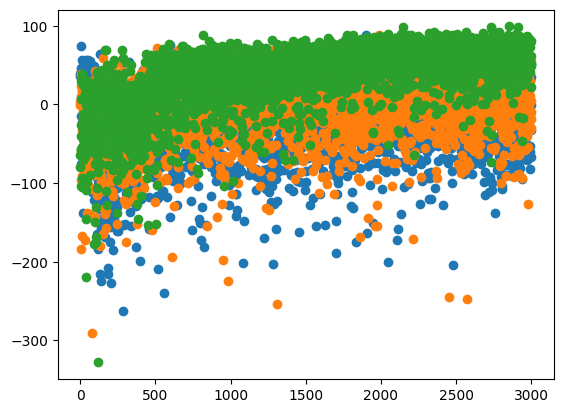

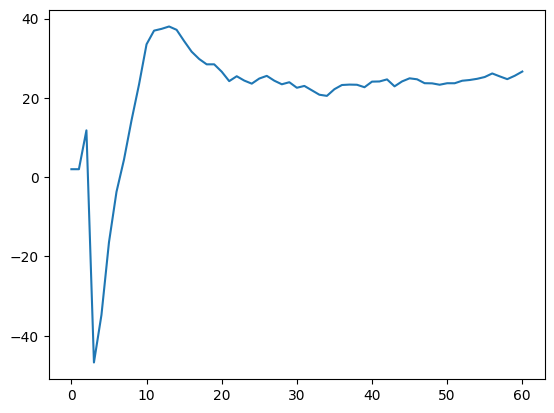

In [44]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

PATH = 'checkpoints/4.2'
NUM_EPISODES = 3000
TAU = 0.005

agent = DQNMultiActionAgent(
    env,
    eps_start=0.7,
    eps_end=0.2,
    learning_rate=1e-5, 
    t_max=NUM_EPISODES,
)

N_eval = np.ceil(NUM_EPISODES/50 + 1).astype(int)
eval_rewards = np.zeros((N_eval, 3))
best_reward = -np.inf
seeds = torch.randint(0,3000,(3,NUM_EPISODES))
for i in range(3):
    train_rewards, eval_rewards[:,i] = train_DQNBinaryAgent(env, agent, NUM_EPISODES, TAU, PATH, SEEDS=seeds[i])
    if eval_rewards[-1,i] > best_reward:
        best_reward = eval_rewards[-1,i]
        agent.save_model(PATH)
    plt.scatter(np.arange(NUM_EPISODES), train_rewards)
    agent.reset()

plt.figure()
plt.plot(eval_rewards.mean(axis=1))

Should we do early stopping? 550 episodes seems optimal

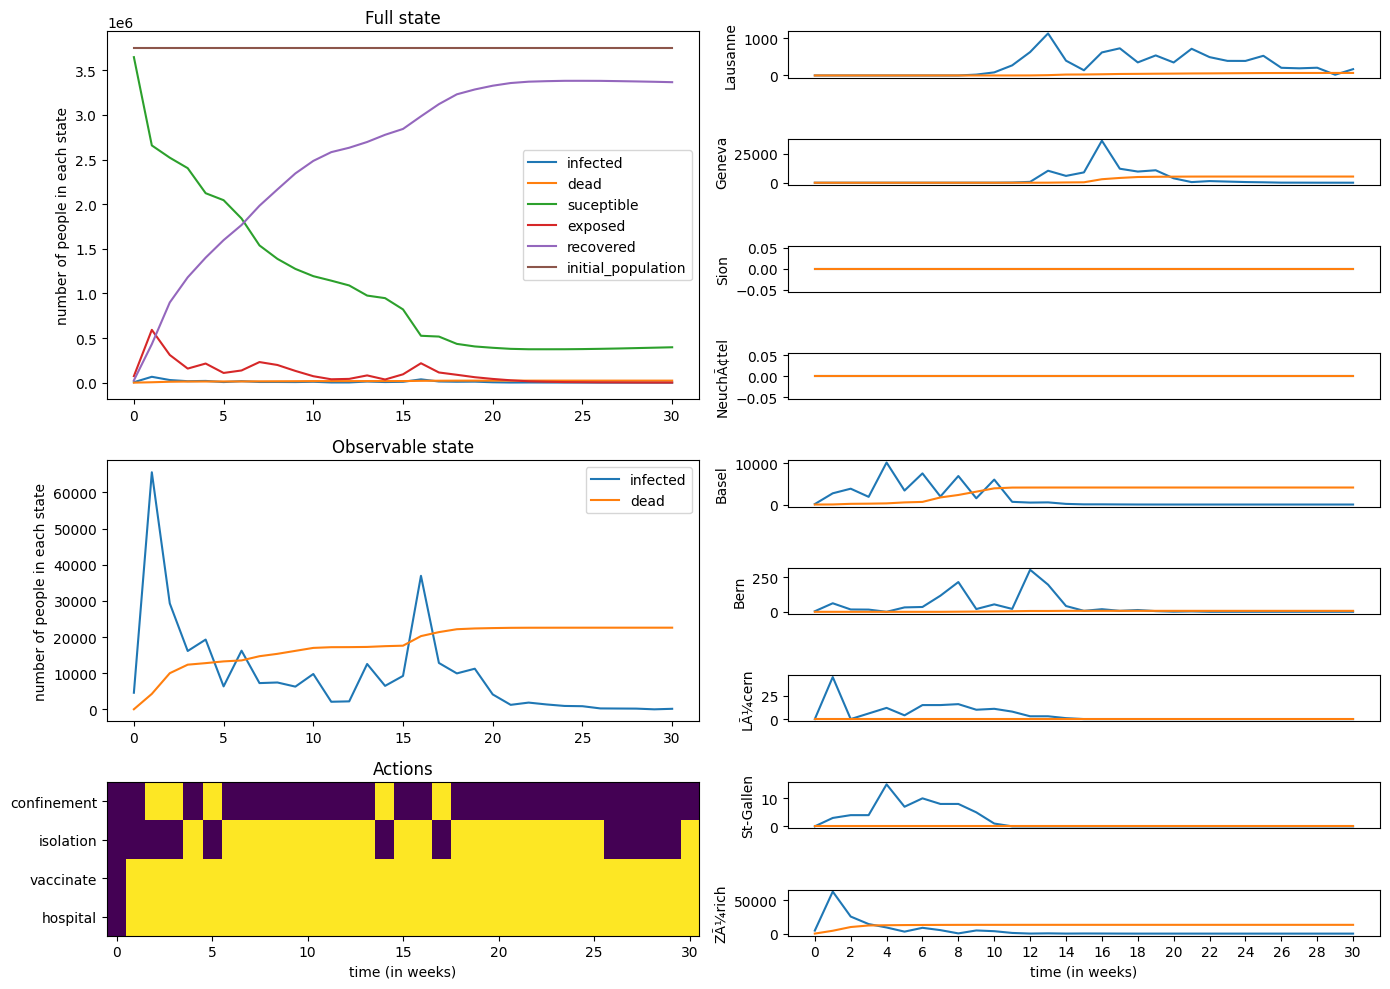

In [48]:
# reload agent
PATH = 'checkpoints/4.2'
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, seed=2)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

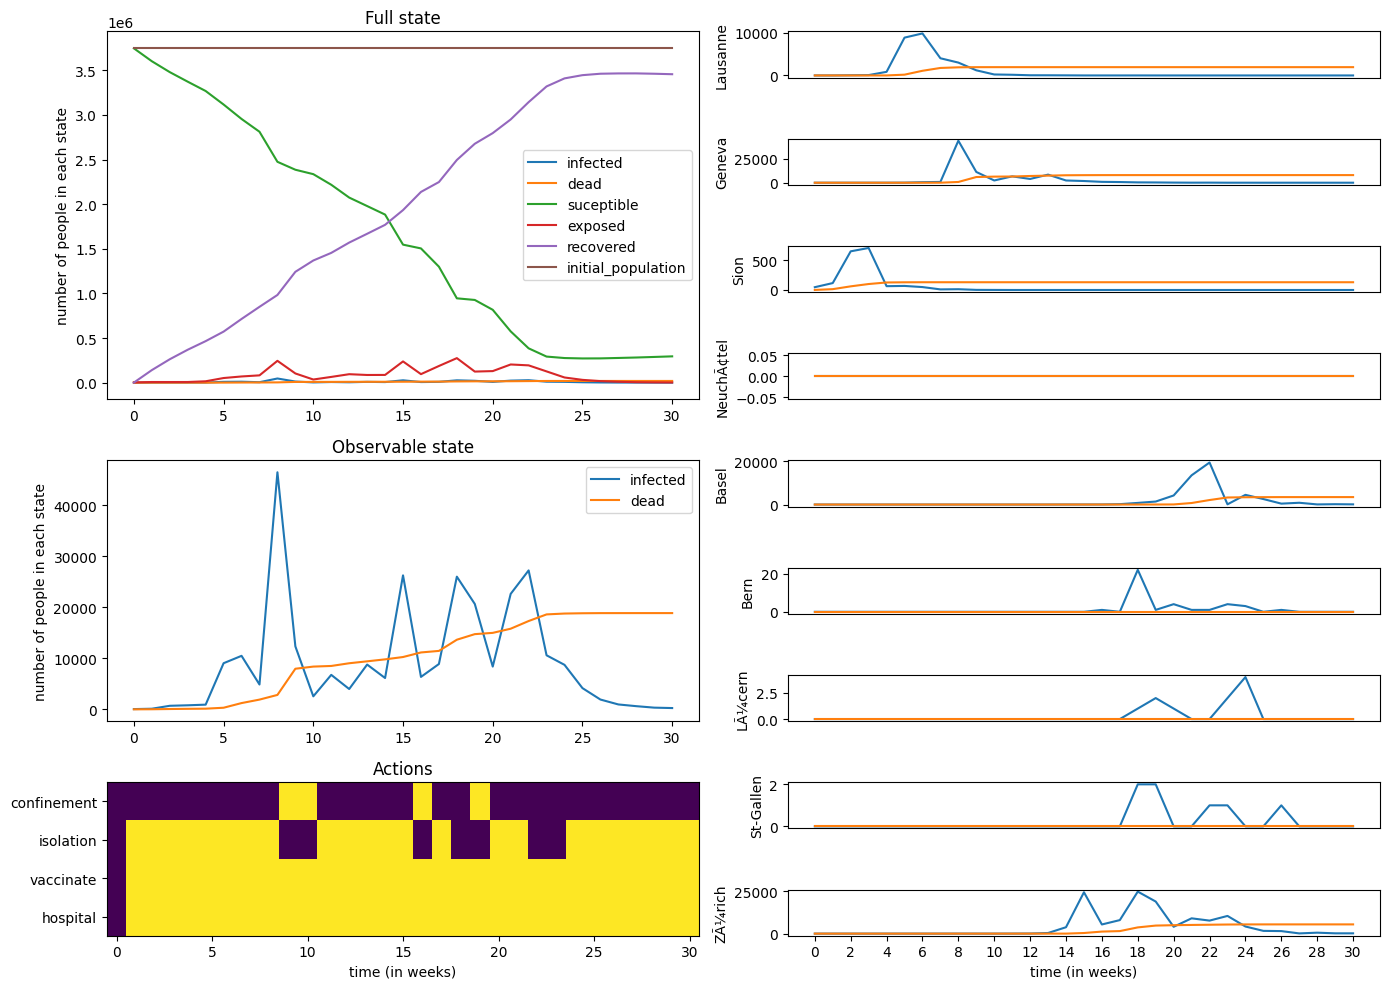

In [49]:
# reload agent
PATH = 'checkpoints/4.2'
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, seed=3)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

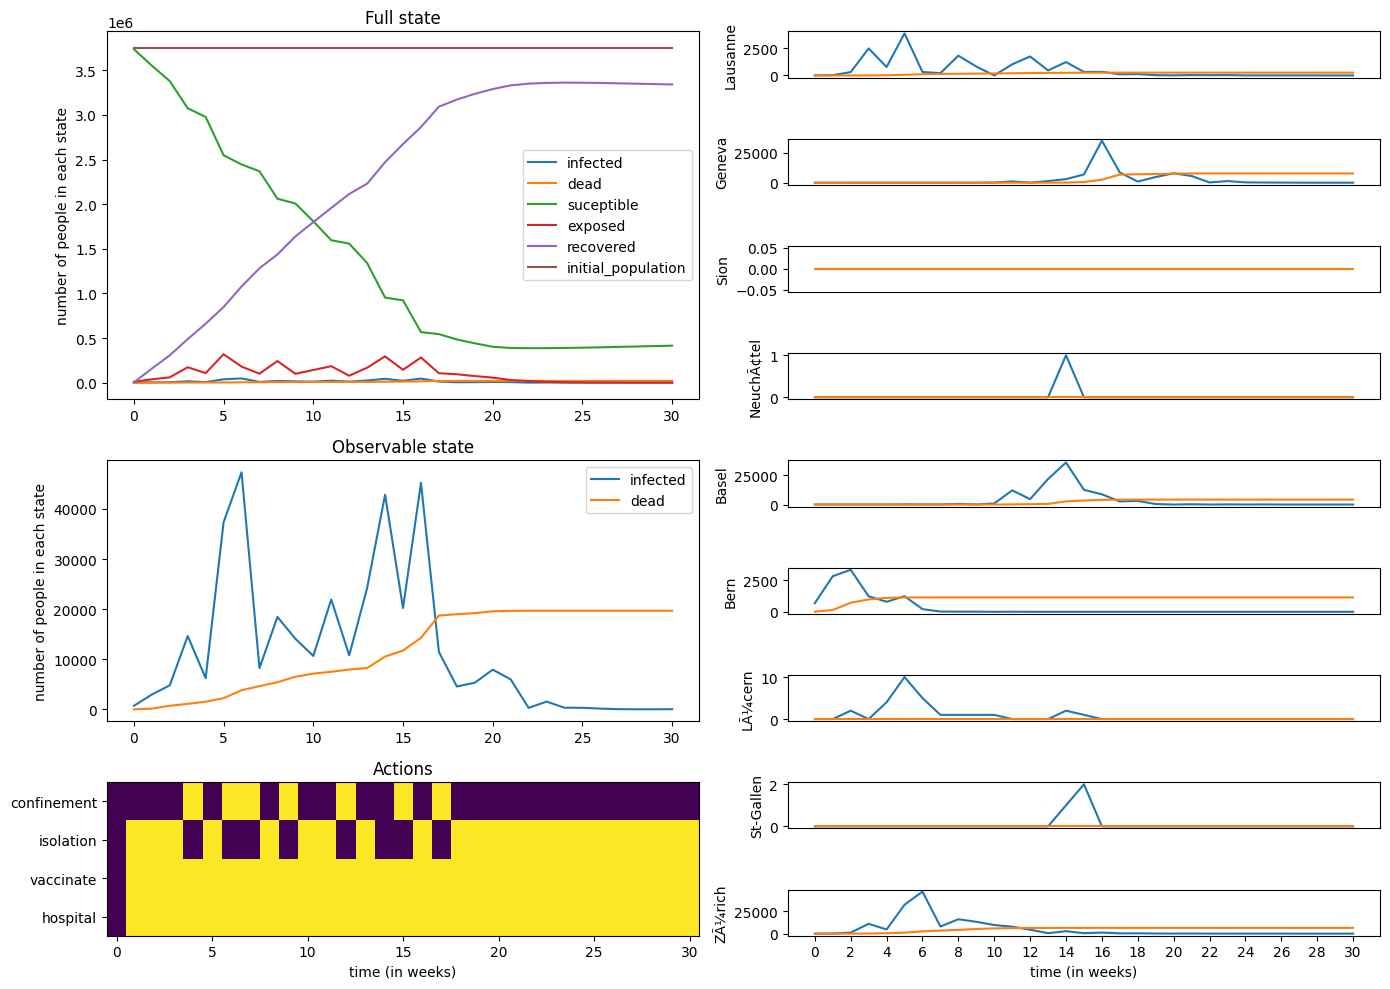

In [50]:
# reload agent
PATH = 'checkpoints/4.2'
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, seed=5)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

32.34 77.96660675048828 21628.42


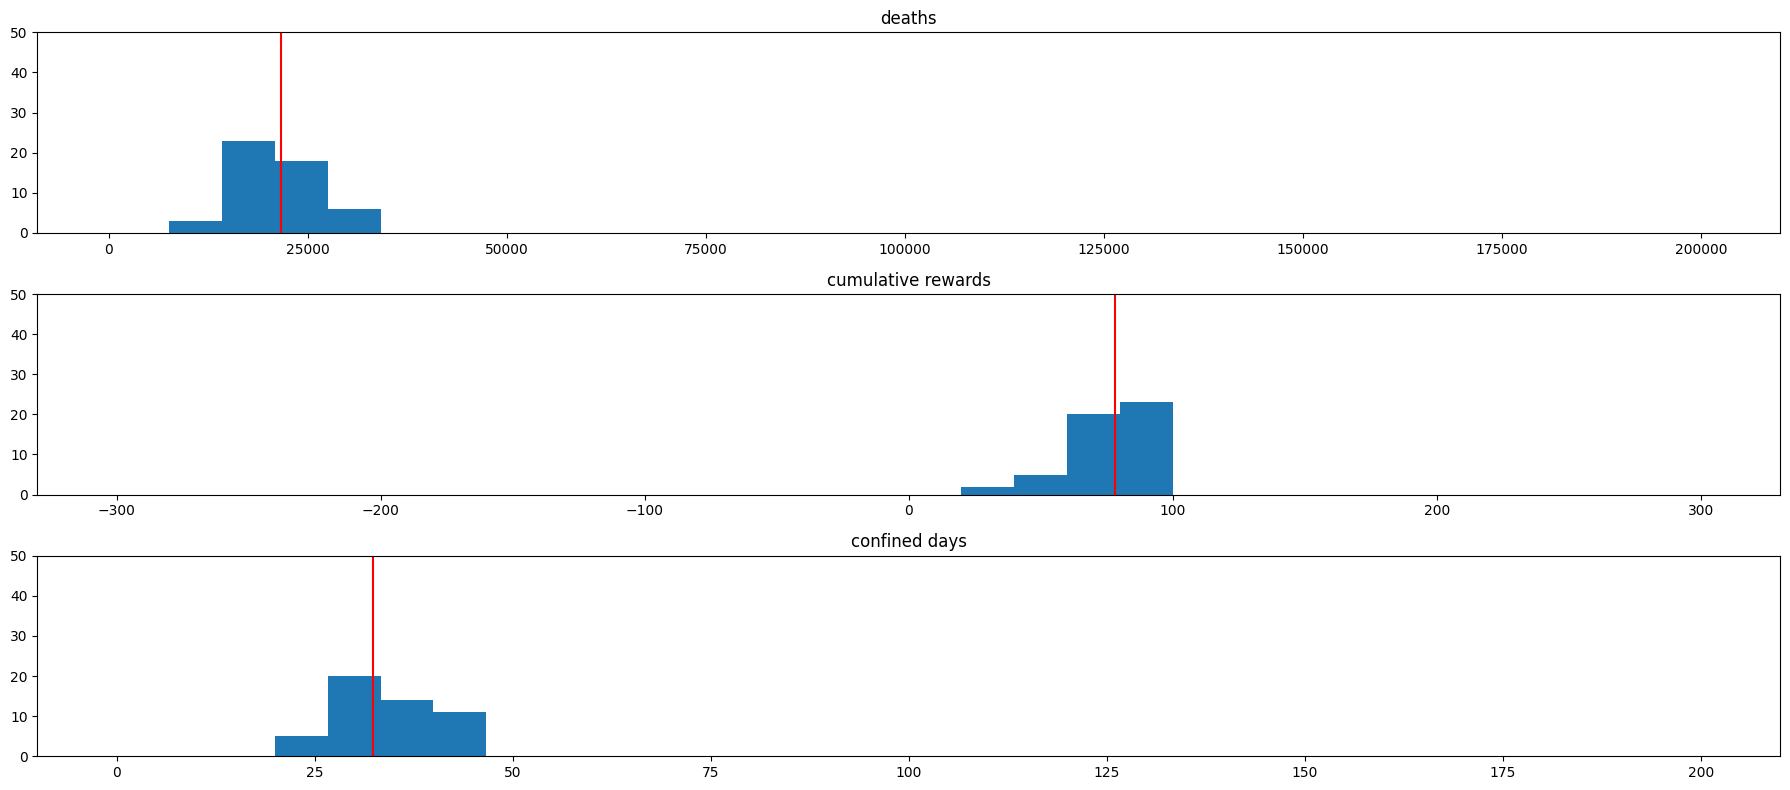

Average death number: 21628.42
Average number of confined days: 32.34
Average cumulative reward: 77.96660675048828


In [46]:
confined_days, cum_rewards, total_deaths = evaluate(env, agent)
print(confined_days.mean(), cum_rewards.mean(), total_deaths.mean())
""" Plot histograms """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=30,range=x_range)
hist_avg(ax[0], total_deaths,'deaths')
hist_avg(ax[1], cum_rewards,'cumulative rewards')
hist_avg(ax[2], confined_days,'confined days')
fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(total_deaths)}')
print(f'Average number of confined days: {np.mean(confined_days)}')
print(f'Average cumulative reward: {np.mean(cum_rewards)}')

100%|██████████| 550/550 [41:57<00:00,  4.58s/it]  


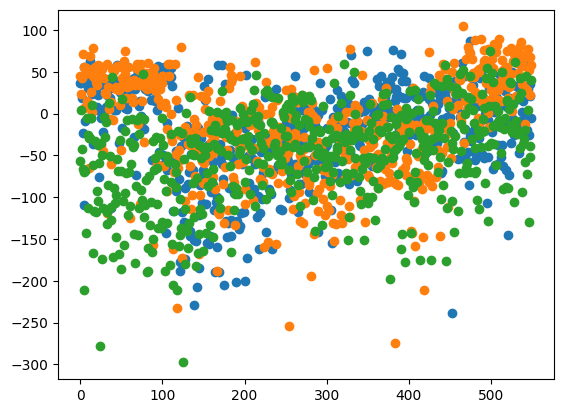

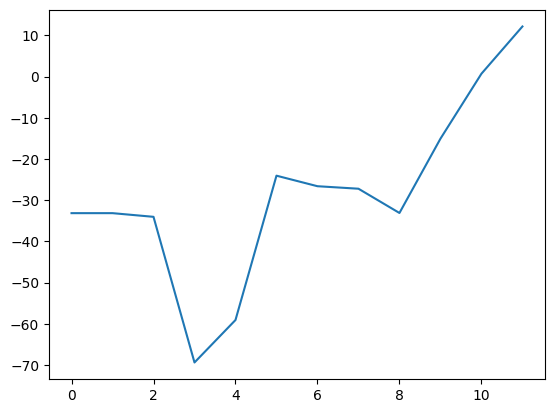

In [51]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

PATH = 'checkpoints/4.2_EarlyStop'
NUM_EPISODES = 550
TAU = 0.005

agent = DQNMultiActionAgent(
    env,
    eps_start=0.7,
    eps_end=0.2,
    learning_rate=1e-5, 
    t_max=NUM_EPISODES,
)

N_eval = np.ceil(NUM_EPISODES/50 + 1).astype(int)
eval_rewards = np.zeros((N_eval, 3))
best_reward = -np.inf
seeds = torch.randint(0,3000,(3,NUM_EPISODES))
for i in range(3):
    train_rewards, eval_rewards[:,i] = train_DQNBinaryAgent(env, agent, NUM_EPISODES, TAU, PATH, SEEDS=seeds[i])
    if eval_rewards[-1,i] > best_reward:
        best_reward = eval_rewards[-1,i]
        agent.save_model(PATH)
    plt.scatter(np.arange(NUM_EPISODES), train_rewards)
    agent.reset()

plt.figure()
plt.plot(eval_rewards.mean(axis=1))

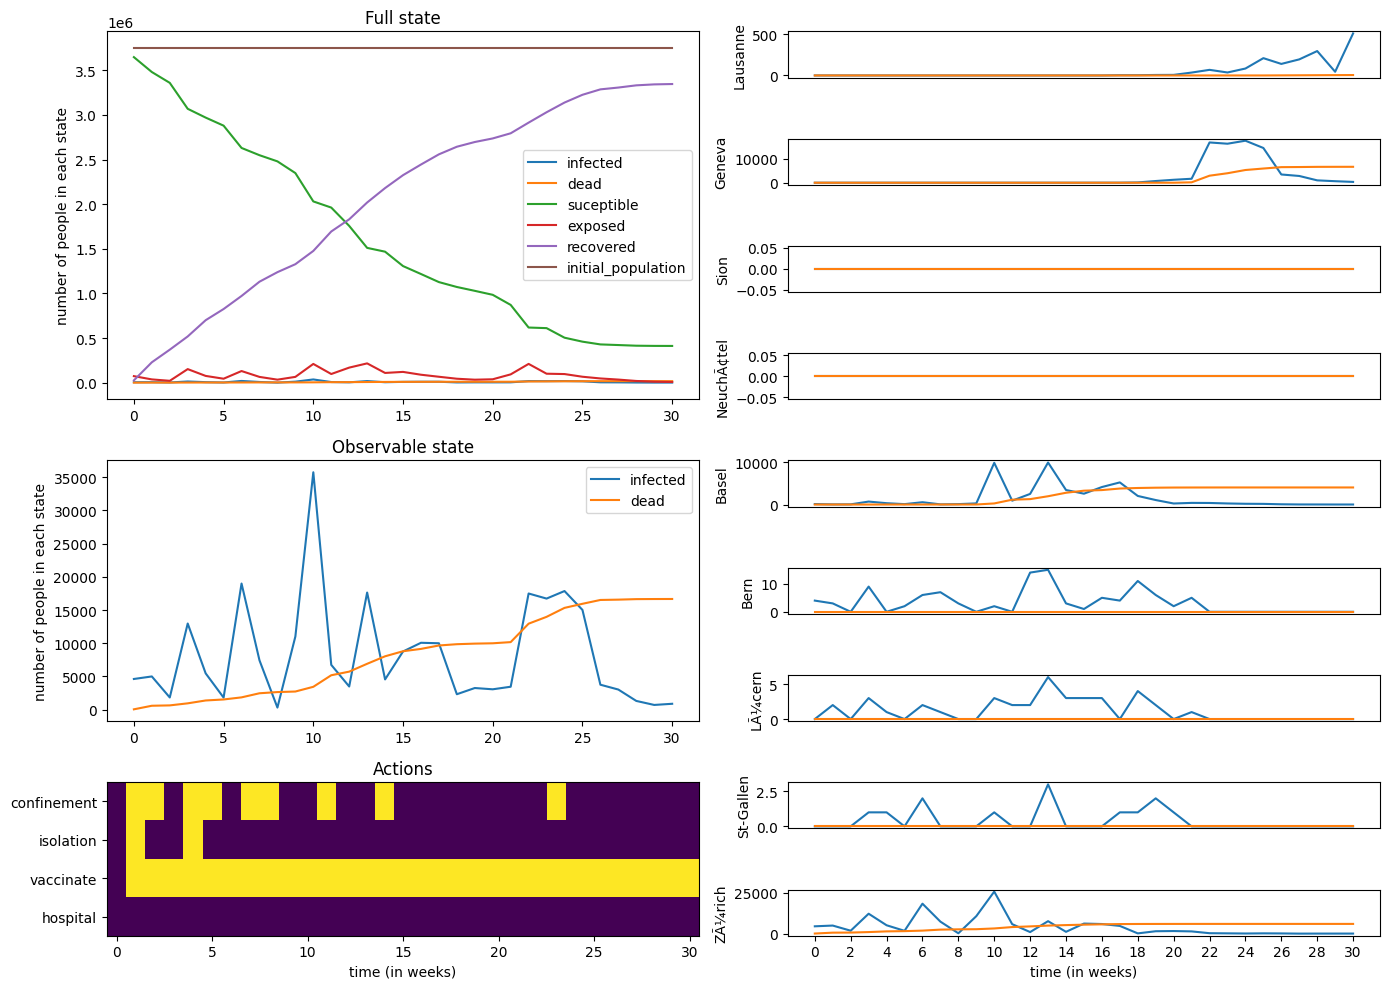

In [52]:
# reload agent
PATH = 'checkpoints/4.2_EarlyStop'
agent.load_model(PATH)

total, cities, actions, _ = run_episode(env, agent, seed=2)

from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(14,10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

[ax_leftstate.plot(y) for y in total.values()]
ax_leftstate.legend(total.keys())
ax_leftstate.set_title('Full state')
ax_leftstate.set_ylabel('number of people in each state')

[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state')
ax_leftobs.set_ylabel('number of people in each state')

ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('time (in weeks)')

[ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
[ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['ZÃ¼rich'].set_xlabel('time (in weeks)')
ax_right['ZÃ¼rich'].xaxis.set_major_locator(MultipleLocator(2.000))

fig.tight_layout()
plt.show()

49.28 63.2367972946167 32621.64


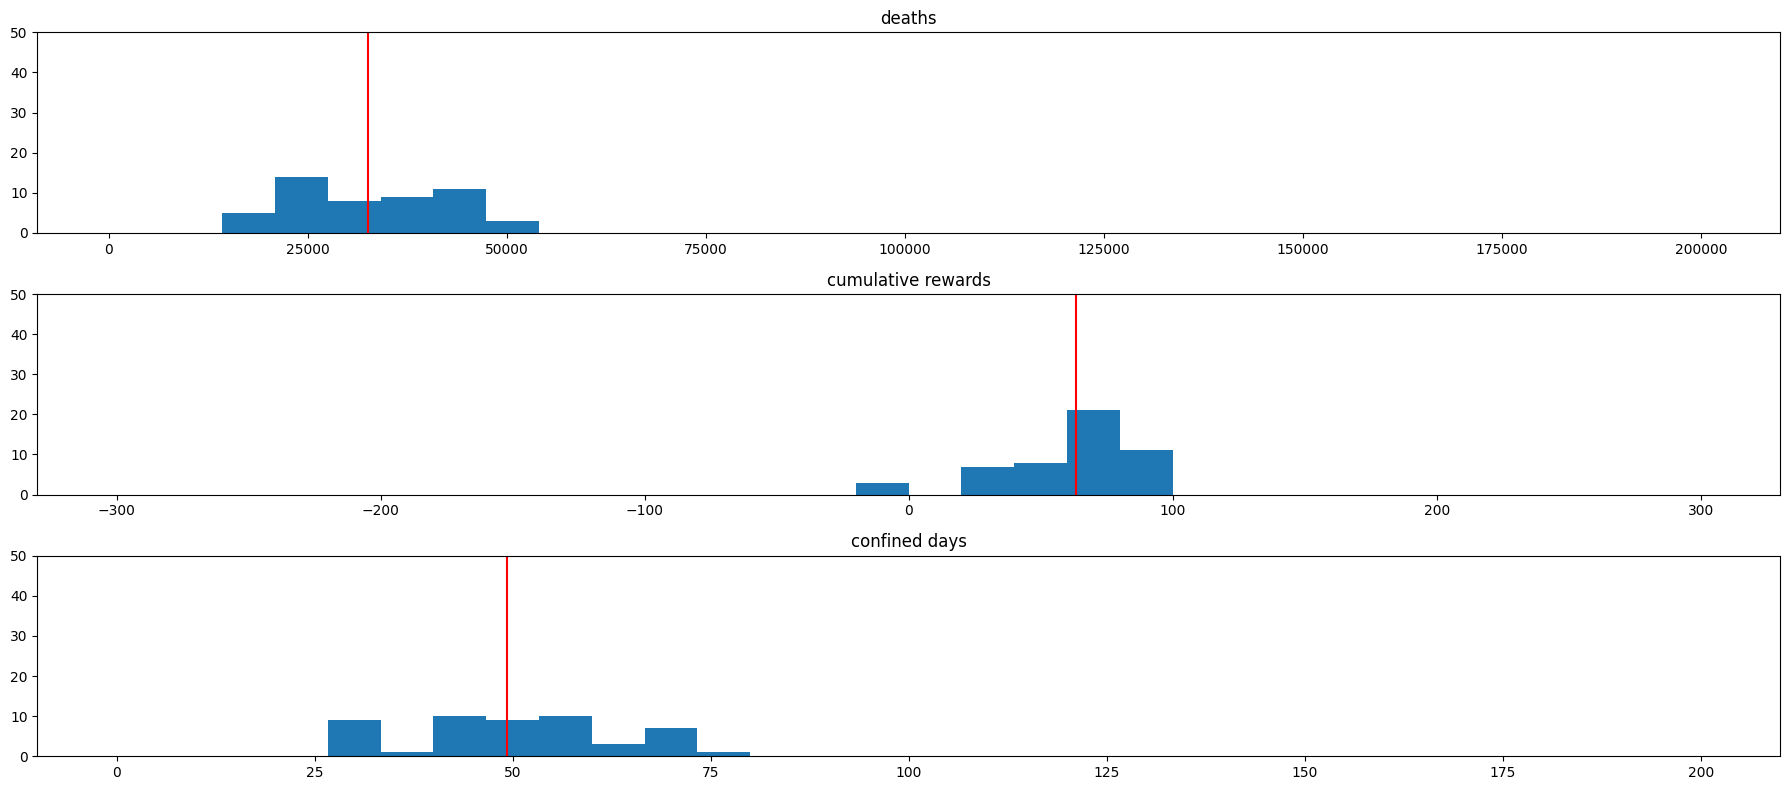

Average death number: 32621.64
Average number of confined days: 49.28
Average cumulative reward: 63.2367972946167


In [53]:
confined_days, cum_rewards, total_deaths = evaluate(env, agent)
print(confined_days.mean(), cum_rewards.mean(), total_deaths.mean())
""" Plot histograms """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=30,range=x_range)
hist_avg(ax[0], total_deaths,'deaths')
hist_avg(ax[1], cum_rewards,'cumulative rewards')
hist_avg(ax[2], confined_days,'confined days')
fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(total_deaths)}')
print(f'Average number of confined days: {np.mean(confined_days)}')
print(f'Average cumulative reward: {np.mean(cum_rewards)}')

# Question 5)

In [66]:
def load_env_agent(AgentName):
    SEED = 2
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.use_deterministic_algorithms(True)
    
    if AgentName == "Russo":
        env = Env(dyn,
            action_space=None,
            observation_space=None,
                 )
        agent = RussoAgent(env)
        
    elif AgentName == "Binary":
        action_space        =   spaces.Discrete(2)
        observation_space   =   spaces.Box( low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16)

        env = Env(  dyn,
                    action_space=action_space,
                    observation_space=observation_space,
                    action_preprocessor=action_preprocessor_Binary,
                    observation_preprocessor=observation_preprocessor_Binary,
                    )
        agent = DQNAgent(env)
        PATH = 'checkpoints/3b'
        agent.load_model(PATH)
    
    elif AgentName == "Toggle":
        action_space        =   spaces.Discrete(5)
        observation_space   =   spaces.Box( low=0,
                                            high=1,
                                            shape=(2 * dyn.n_cities * dyn.env_step_length + 4,),
                                            dtype=np.float16)

        env = Env(  dyn,
                    action_space=action_space,
                    observation_space=observation_space,
                    action_preprocessor=action_preprocessor_Toggle,
                    observation_preprocessor=observation_preprocessor_Toggle,
                    )

        agent = DQNAgent(
            env,
            obs_size = 2*9*7+4,
            num_actions=5,
        )
        PATH = 'checkpoints/4.1'
        agent.load_model(PATH)
        
    elif AgentName == "Factorized":
        action_space        =   spaces.MultiBinary(4)
        observation_space   =   spaces.Box( low=0,
                                            high=1,
                                            shape=(2, dyn.n_cities, dyn.env_step_length),
                                            dtype=np.float16)

        env = Env(  dyn,
                    action_space=action_space,
                    observation_space=observation_space,
                    action_preprocessor=action_preprocessor_Factorized,
                    observation_preprocessor=observation_preprocessor_Factorized,
                    )
        PATH = 'checkpoints/4.2'
        agent = DQNMultiActionAgent(env)
        agent.load_model(PATH)
    
    return env, agent

In [76]:
def Compute_features_agent(env: Env, agent: Agent, num_episodes=50):
    np.random.seed(2)
    confined_days = np.zeros(num_episodes, dtype=int)
    isolation_days = np.zeros(num_episodes, dtype=int)
    vaccination_days = np.zeros(num_episodes, dtype=int)
    add_hosp_beds_days = np.zeros(num_episodes, dtype=int)
    cum_rewards = np.zeros(num_episodes)
    total_deaths = np.zeros(num_episodes, dtype=int)
    for episode in range(num_episodes):
        total, _, actions, cum_reward = run_episode(env, agent, np.random.randint(0, 1000))
        confined_days[episode] = int(actions['confinement'].sum() * 7)
        isolation_days[episode] = int(actions['isolation'].sum() * 7)
        vaccination_days[episode] = int(actions['vaccinate'].sum() * 7)
        add_hosp_beds_days[episode] = int(actions['hospital'].sum() * 7)
        cum_rewards[episode] = cum_reward
        total_deaths[episode] = total['dead'][-1]
    return np.array([confined_days, isolation_days, vaccination_days, add_hosp_beds_days, total_deaths, cum_rewards]).mean(1).astype(int)

In [77]:
Features = {"Russo":np.zeros(6).astype(int), 
            "Binary":np.zeros(6).astype(int), 
            "Toggle":np.zeros(6).astype(int), 
            "Factorized":np.zeros(6).astype(int)}
with torch.no_grad():
    for AgentName in Features.keys():
        print(AgentName)
        env, agent = load_env_agent(AgentName)
        Features[AgentName][:] = Compute_features_agent(env, agent)

Russo
Binary
Toggle
Factorized


In [78]:
Features

{'Russo': array([  100,     0,     0,     0, 54321,   -39]),
 'Binary': array([ 151,    0,    0,    0, 3002,   63]),
 'Toggle': array([  112,    10,   117,    69, 11615,    57]),
 'Factorized': array([   32,   140,   210,   210, 21628,    77])}